<a href="https://colab.research.google.com/github/spanman888/DSC672_Teacher_Salary/blob/master/Capstone_Teacher_Salary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import os
import numpy as np
import math
import time

from sklearn.model_selection import cross_validate, train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

pd.set_option('display.max_columns', 100)

In [0]:
# In order to download files to local file system
from google.colab import drive
drive.mount('drive')



Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
#Load teacher data from GitHub
url2003 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2003_tsr_public_dataset.csv'
url2004 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2004_tsr_public_dataset.csv'
url2005 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2005_tsr_public_dataset.csv'
url2006 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2006_tsr_public_dataset.csv'
url2007 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2007_tsr_public_dataset.csv'
url2008 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2008_tsr_public_dataset.csv'
url2009 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2009_tsr_public_dataset.csv'
url2010 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2010_tsr_public_dataset.csv'
url2011 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2011_tsr_public_dataset.csv'
url2012 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2012-tsr-public-dataset.csv'

#Load inflation data from GitHub
inflation_GitHub = 'https://github.com/spanman888/DSC672_Teacher_Salary/blob/master/DSC672_Data/CPIAUCNS_2003_2019.xls?raw=true'

In [0]:
#Combine all teacher data into one dataframe
df = pd.concat(map(pd.read_csv, [url2003, url2004,url2005,url2006,url2007,url2008,url2009,url2010,url2011,url2012]))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,34,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,7,8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [0]:
#Count number of records for all variables
df.count()

fy                     1624887
rcdt                   1624887
dst_name               1624846
dst_addr               1624846
dst_city               1624846
dst_st                 1624846
dst_zip                1624846
dst_zip_plus4          1624846
sch_num                1624887
sch_name               1624866
sch_addr               1503783
sch_city               1503783
sch_st                 1503783
sch_zip                1503783
sch_zip_plus4          1503783
last_name              1624887
first_name             1624887
mid_init               1624887
gender                 1624887
race_ethnicity_cd      1624559
race_ethnicity_desc    1624468
tsr_status_cd          1624887
tsr_status_desc        1624887
location_cd            1624878
location_desc          1624833
emply_type             1624887
emply_desc             1624665
salary                 1624887
months_employed        1624887
pct_emp                1624887
                        ...   
dist_exp               1624887
state_ex

In [0]:
#moving salary to first column
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('salary')))
cols

df = df.reindex(columns= cols)

In [0]:
#Create column with first three of zip
df['first_3'] = df['dst_zip'].astype(str).str[0:3]

#Assign suburb zips to a list
suburb = ['600','601','603','604','605','607','608']

#Create new Zip_Type column and assign based on first three of zip or where city is Chicago
#A suburb is any first three of ZIP that touches the 606XX zip code and is not Chicago
df['Zip_Type'] = np.where(df["first_3"].isin(suburb), "Suburb", "Other")
df['Zip_Type'] = np.where(df["dst_city"] == 'Chicago', 'Chicago', df["Zip_Type"])

In [0]:
print(df['Zip_Type'].value_counts())

Suburb     790630
Other      558018
Chicago    276239
Name: Zip_Type, dtype: int64


In [0]:
#Loading inflation data
inflation = pd.read_excel(inflation_GitHub, sheet_name='FRED Graph')

#Indexing inflation to latest value in data (2019 data)
inflation['CPI_Multiplier'] = inflation['CPIAUCNS'].iloc[-1] / inflation['CPIAUCNS']

#Breaking out year and date columns
inflation['year'] = inflation['observation_date'].dt.year
inflation['month'] = inflation['observation_date'].dt.month

#Only keeping Jan 1 values for each year
inflation = inflation[inflation['month'] == 1]

#Only keeping CPI Multiplier and year
inflation = inflation.drop(['observation_date','CPIAUCNS', 'month'], axis=1)

#Matching column names with data
inflation.columns = ['CPI_Multiplier', 'fy']

# merge dataframe
df = pd.merge(df, inflation, how='left', on='fy')

#Inflation adjusting salary by multiplying salary by CPI Multiplier
df['CPIAdjSalary'] = df['salary'] * df['CPI_Multiplier'] 


In [0]:
#Adding Inflation Adjusted Salary per Month
df['AdjSalMonth'] = df['CPIAdjSalary'] / df['months_employed'] 

#Adding Non-Inflation Adjusted Salary per Month
df['SalMonth'] = df['salary'] / df['months_employed'] 

In [0]:
#moving CPIAdjSalary to first column
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('CPIAdjSalary')))
cols

df = df.reindex(columns= cols)


In [0]:
#removing assignment_4 thru assign7_desc variables; tsr_status variables; state variables; teacher names columns

df = df.drop(['assignment_4', 'assign4_desc', 'assignment_5','assign5_desc','assignment_6','assign6_desc','assignment_7','assign7_desc', 'dst_st', 'sch_st','tsr_status_cd', 'tsr_status_desc', 'mid_init','last_name','first_name'], axis=1)


In [0]:
#removing info on specific bachelor/advanced degree schools
df = df.drop(['bacc_coll','bacc_coll_desc','adv_coll','adv_coll_desc'],axis=1)


In [0]:
#creating variables denoting 2 or 3 assignments
def assign(x):
    if x > 0:
      return 1
    else:
      return 0

df["multi_assign_2"] = df["assignment_2"].apply(assign)
df["multi_assign_3"] = df["assignment_3"].apply(assign)

In [0]:
#removing assignment_2 and assignment_3 variables
df = df.drop(['assignment_2','assign2_desc','assignment_3','assign3_desc'],axis=1)

In [0]:
#removing pct_emp varialbe - same values as fte; also removing emply_type
df = df.drop(['pct_emp', 'emply_type'],axis=1)

In [0]:
#removing zip code + 4 features variable - postal route not useful for analysis
df = df.drop(['dst_zip_plus4'],axis=1)

In [0]:
!pip install missingno
import missingno as msno

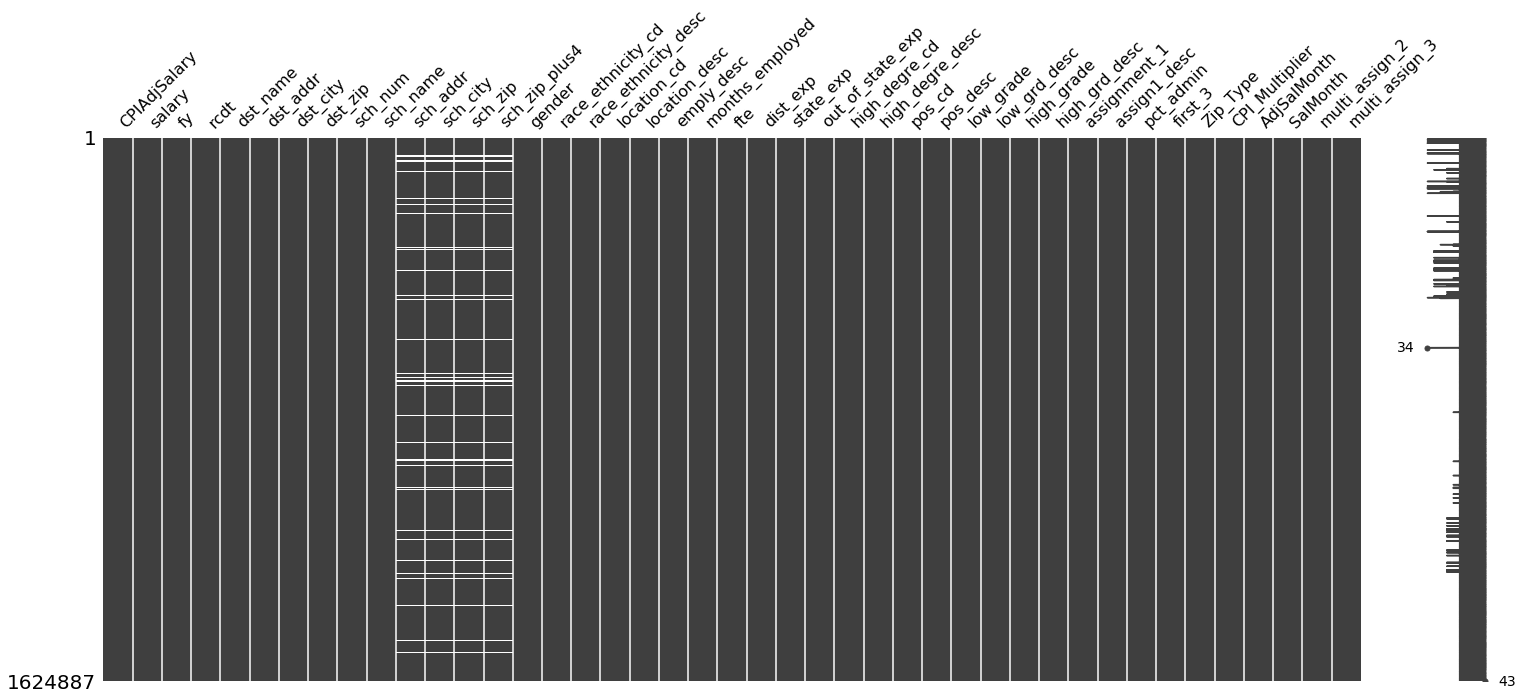

In [0]:
msno.matrix(df)

This shows that most of the missing data are in the school location columns. There doesn't seem to be a pattern of the missing values. The highest amount of missing variables is 7 for a particular (out of 39 possible variables at this point).

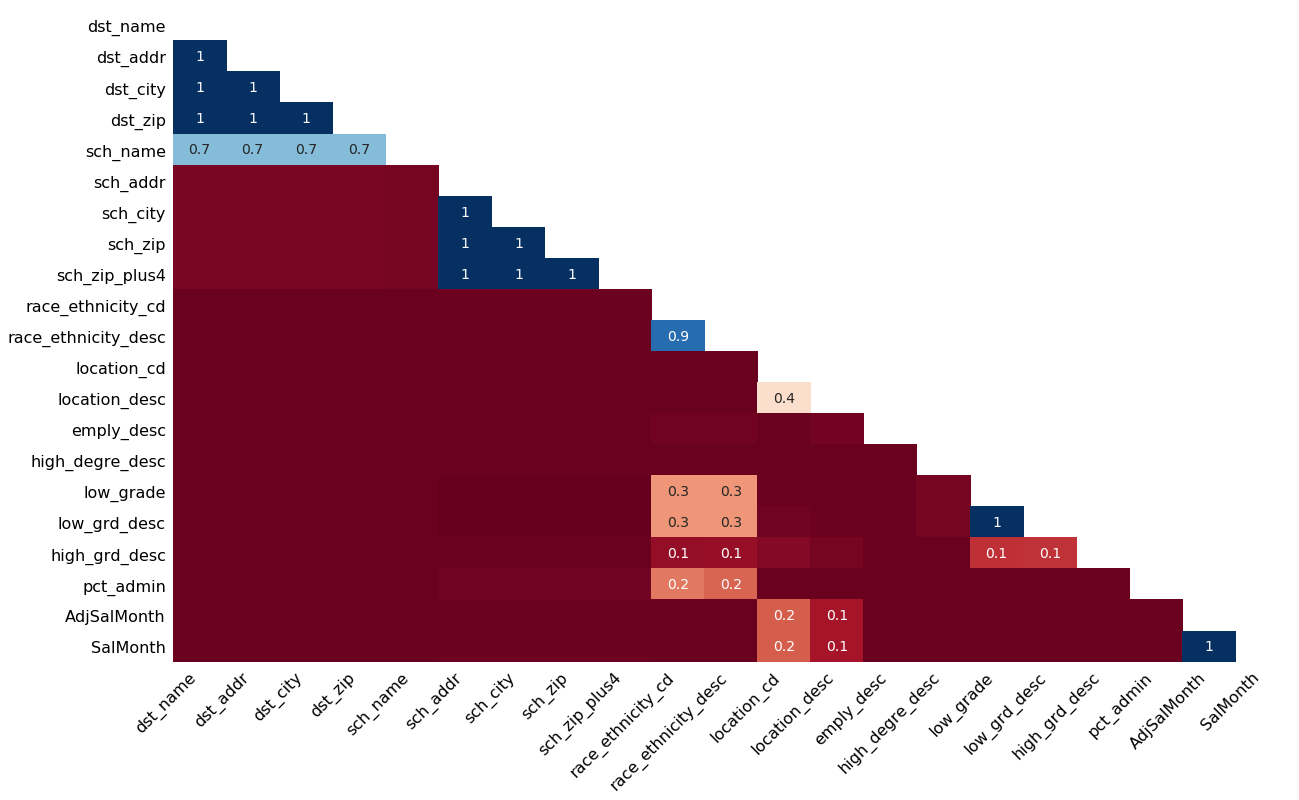

In [0]:
#Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) 
#to 1 (if one variable appears the other definitely also does).
msno.heatmap(df)

The above suggests that when there is some district information there is all district information. There is also a slight correlation between having the low grade variable and race ethnicity information. There doesn't seem to be much correlation between other missing variables. Both of these plots suggest we can remove missing variables as there are not clear patterns to the missing data and we have enough full records. 

In [0]:
#dropping all rows with NA values
df = df.dropna()

In [0]:
#row count
df.shape

(1501683, 43)

In [0]:
#Calculate Z-Scores for Adjusted Salary per Month and add as a column
from scipy import stats
df['z_score'] = np.abs(stats.zscore(df['AdjSalMonth']))

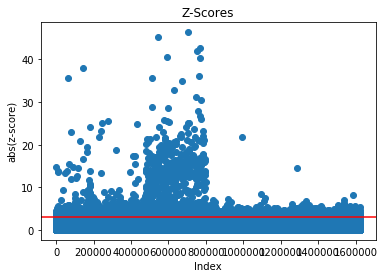

In [0]:
import matplotlib.pyplot as plt
plt.scatter(x=df.index, y='z_score', data=df)
plt.title('Z-Scores')
plt.ylabel('abs(z-score)')
plt.xlabel('Index')
plt.axhline(y=3, color='red')
plt.show()

In [0]:
#Outliers are where absolute value of z-score > 3 or salary is equal to 0
df_outliers = df[(df["z_score"] > 4 ) | (df["salary"] < 1 )]
df_outliers.describe()

,CPIAdjSalary,salary,fy,dst_zip,sch_zip,months_employed,fte,dist_exp,state_exp,out_of_state_exp,high_degre_cd,pos_cd,assignment_1,pct_admin,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3,z_score
count,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000,5936.000000
mean,44252.877895,34723.323767,2008.800034,60762.888140,60764.006907,8.516341,77.431267,12.232463,16.742183,0.464134,4.640162,22.889656,179.890667,12.634771,1.209887,8487.897280,6654.860842,0.255391,0.091981,4.168043
std,80128.257073,62991.499319,2.512769,867.201113,861.875861,2.903747,32.843588,12.168600,13.318904,2.086983,0.677398,11.153888,158.870212,32.564260,0.073580,15415.619783,12073.857745,0.436117,0.289024,3.615067
min,0.000000,0.000000,2003.000000,60002.000000,60002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.121488,0.000000,0.000000,0.000000,0.000000,2.837603
25%,0.000000,0.000000,2007.000000,60084.000000,60085.000000,9.000000,50.000000,2.000000,4.000000,0.000000,4.000000,19.000000,55.000000,0.000000,1.154294,0.000000,0.000000,0.000000,0.000000,2.837605
50%,0.000000,0.000000,2009.000000,60473.000000,60460.000000,9.000000,100.000000,7.000000,14.000000,0.000000,5.000000,20.000000,147.000000,0.000000,1.203933,0.000000,0.000000,0.000000,0.000000,2.837605
75%,49378.891523,38991.917500,2011.000000,61252.000000,61201.000000,10.000000,100.000000,21.000000,31.000000,0.000000,5.000000,22.000000,321.000000,0.000000,1.255839,19529.841909,15003.693114,1.000000,0.000000,4.148081
max,566105.161997,441612.000000,2012.000000,62995.000000,62995.000000,12.000000,100.000000,49.000000,50.000000,34.000000,6.000000,64.000000,606.000000,100.000000,1.399020,137608.709223,109575.080000,1.000000,1.000000,46.384051


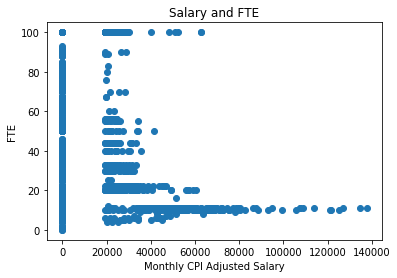

In [0]:
import matplotlib.pyplot as plt
plt.scatter(x=df_outliers.AdjSalMonth, y=df_outliers.fte, data=df_outliers)
plt.title('Salary and FTE')
plt.ylabel('FTE')
plt.xlabel('Monthly CPI Adjusted Salary')
plt.show()

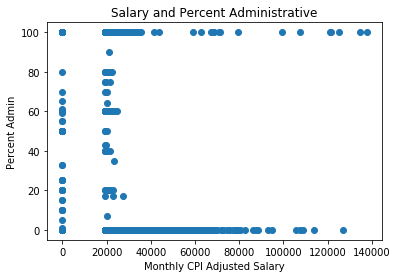

In [0]:
import matplotlib.pyplot as plt
plt.scatter(x=df_outliers.AdjSalMonth, y=df_outliers.pct_admin, data=df_outliers)
plt.title('Salary and Percent Administrative')
plt.ylabel('Percent Admin')
plt.xlabel('Monthly CPI Adjusted Salary')
plt.show()

There is a high percentage of outliers at both 0 and 100% administrative.

In [0]:
df_not_outliers= df[(df["z_score"] < 4) & (df["salary"] != 0)]
df_not_outliers.describe()

,CPIAdjSalary,salary,fy,dst_zip,sch_zip,months_employed,fte,dist_exp,state_exp,out_of_state_exp,high_degre_cd,pos_cd,assignment_1,pct_admin,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3,z_score
count,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06,1.495748e+06
mean,7.521042e+04,6.055965e+04,2.007531e+03,6.086935e+04,6.087592e+04,9.436023e+00,9.804928e+01,1.119595e+01,1.319911e+01,3.786204e-01,4.579743e+00,2.099570e+01,1.554023e+02,4.868222e+00,1.248978e+00,7.930868e+03,6.384123e+03,2.294397e-01,6.688426e-02,7.473704e-01
std,2.709219e+04,2.234266e+04,2.868525e+00,8.313182e+02,8.291597e+02,7.824212e-01,9.751213e+00,9.276611e+00,9.727213e+00,1.850920e+00,5.411117e-01,7.502957e+00,1.684506e+02,2.124274e+01,8.981994e-02,2.627318e+03,2.168374e+03,4.204727e-01,2.498215e-01,5.697464e-01
min,4.692520e-02,4.000000e-02,2.003000e+03,4.837500e+04,6.000200e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.121488e+00,4.692520e-03,4.000000e-03,0.000000e+00,0.000000e+00,3.333559e-07
25%,5.558286e+04,4.438992e+04,2.005000e+03,6.018500e+04,6.018500e+04,9.000000e+00,1.000000e+02,4.000000e+00,5.000000e+00,0.000000e+00,4.000000e+00,1.900000e+01,3.700000e+01,0.000000e+00,1.173130e+00,5.992728e+03,4.795298e+03,0.000000e+00,0.000000e+00,3.285238e-01
50%,7.026440e+04,5.664800e+04,2.008000e+03,6.060300e+04,6.060900e+04,9.000000e+00,1.000000e+02,8.000000e+00,1.100000e+01,0.000000e+00,5.000000e+00,1.900000e+01,5.900000e+01,0.000000e+00,1.204292e+00,7.535205e+03,6.071111e+03,0.000000e+00,0.000000e+00,6.465617e-01
75%,9.111873e+04,7.330605e+04,2.010000e+03,6.135000e+04,6.135000e+04,1.000000e+01,1.000000e+02,1.600000e+01,1.900000e+01,0.000000e+00,5.000000e+00,2.200000e+01,2.220000e+02,0.000000e+00,1.332994e+00,9.537815e+03,7.679017e+03,0.000000e+00,0.000000e+00,1.012678e+00
max,2.292356e+05,2.031281e+05,2.012000e+03,6.299900e+04,6.299900e+04,1.500000e+01,1.000000e+02,6.300000e+01,6.300000e+01,4.500000e+01,6.000000e+00,6.500000e+01,6.070000e+02,1.000000e+02,1.399020e+00,1.911355e+04,1.701667e+04,1.000000e+00,1.000000e+00,3.999178e+00


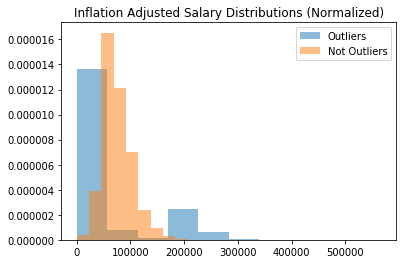

In [0]:
x = [df_outliers['CPIAdjSalary']]
y = [df_not_outliers['CPIAdjSalary']]

plt.hist(x, alpha=0.5, label='Outliers', density = True)
plt.hist(y, alpha=0.5, label='Not Outliers', density = True)
plt.legend(loc='upper right')
plt.title('Inflation Adjusted Salary Distributions (Normalized)')
plt.show()

We see again the large amount of outliers at 0 and above 100000 (inflation adjusted)

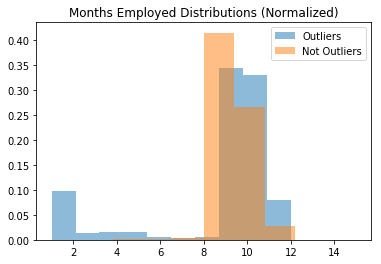

In [0]:
x = [df_outliers['months_employed']]
y = [df_not_outliers['months_employed']]

plt.hist(x, alpha=0.5, label='Outliers', density = True)
plt.hist(y, alpha=0.5, label='Not Outliers', density = True)
plt.legend(loc='upper right')
plt.title('Months Employed Distributions (Normalized)')
plt.show()

Outliers have more at 0 - 5 months employed as well as 12 months. 

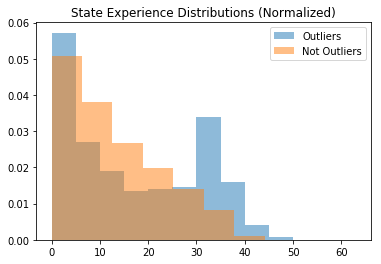

In [0]:
x = [df_outliers['state_exp']]
y = [df_not_outliers['state_exp']]

plt.hist(x, alpha=0.5, label='Outliers', density = True)
plt.hist(y, alpha=0.5, label='Not Outliers', density = True)
plt.legend(loc='upper right')
plt.title('State Experience Distributions (Normalized)')
plt.show()

Outliers skew much higher for In State Experience with many over 30 year. 

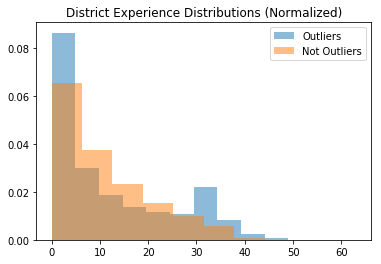

In [0]:
x = [df_outliers['dist_exp']]
y = [df_not_outliers['dist_exp']]

plt.hist(x, alpha=0.5, label='Outliers', density = True)
plt.hist(y, alpha=0.5, label='Not Outliers', density = True)
plt.legend(loc='upper right')
plt.title('District Experience Distributions (Normalized)')
plt.show()

Again we see much more discrict experience with the outliers. 

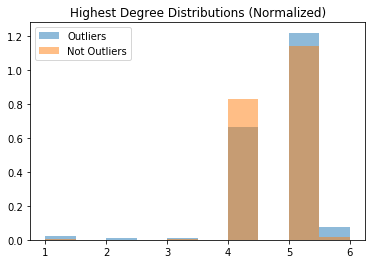

In [0]:
x = [df_outliers['high_degre_cd']]
y = [df_not_outliers['high_degre_cd']]

plt.hist(x, alpha=0.5, label='Outliers', density = True)
plt.hist(y, alpha=0.5, label='Not Outliers', density = True)
plt.legend(loc='upper left')
plt.title('Highest Degree Distributions (Normalized)')
plt.show()

Outliers have more education themselves. 

In [0]:
df.shape

(1501683, 44)

In [0]:
df.nlargest(10, "salary", keep='first')

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_addr,dst_city,dst_zip,sch_num,sch_name,sch_addr,sch_city,sch_zip,sch_zip_plus4,gender,race_ethnicity_cd,race_ethnicity_desc,location_cd,location_desc,emply_desc,months_employed,fte,dist_exp,state_exp,out_of_state_exp,high_degre_cd,high_degre_desc,pos_cd,pos_desc,low_grade,low_grd_desc,high_grade,high_grd_desc,assignment_1,assign1_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3,z_score
579556,566105.161997,441612.00,2006,44063026004,Cary CCSD 26,2115 Crystal Lake Rd,Cary,60013.0,1004,Cary Jr High School,2109 Crystal Lake Rd,Cary,60013.0,1426,F,1,"White, Non-Hispanic",A,One School in this District,Full-Time,9,100,5.0,5.0,0.0,5,Masters,20,Junior High/Middle Teacher,00,NONE,08,Eighth,25,Spanish,0.0,600,Suburb,1.281906,62900.573555,49068.000000,0,0,19.661483
586448,563786.193676,439803.00,2006,06016088002,Bellwood SD 88,2500 Oak St,Bellwood,60104.0,1007,Roosevelt Middle School,2500 Oak St,Bellwood,60104.0,1525,F,2,"Black, Non-Hispanic",A,One School in this District,Full-Time,9,100,1.0,1.0,0.0,5,Masters,20,Junior High/Middle Teacher,06,Sixth,08,Eighth,58,Language Arts (Grades 1-8 Only),0.0,601,Suburb,1.281906,62642.910408,48867.000000,1,0,19.569318
1287086,484502.651290,413000.00,2010,15016299025,City of Chicago SD 299,125 S Clark St,Chicago,60603.0,2799,Curtis Elem School,32 E 115th St,Chicago,60628.0,5510,F,2,"Black, Non-Hispanic",A,One School in this District,Full-Time,10,100,28.0,28.0,0.0,5,Masters,18,Special Education Teacher,0K,Kindergarten,05,Fifth,404,Learning Behavior Specialist I,0.0,606,Chicago,1.173130,48450.265129,41300.000000,1,0,14.492710
594764,471741.482602,368000.00,2006,06016088002,Bellwood SD 88,2500 Oak St,Bellwood,60104.0,2006,Thurgood Marshall Elem School,2501 25th Ave,Bellwood,60104.0,1591,F,1,"White, Non-Hispanic",A,One School in this District,Full-Time,9,100,2.0,2.0,0.0,4,Baccalaureate,19,Elementary Teacher,00,NONE,01,First,55,Elementary Self Contained (K-5 Only),0.0,601,Suburb,1.281906,52415.720289,40888.888889,0,0,15.911125
610058,456689.532256,356258.15,2006,06016087002,Berkeley SD 87,1200 N Wolf Rd,Berkeley,60163.0,2007,J W Riley Elem School,123 S Wolf Rd,Northlake,60164.0,2353,F,1,"White, Non-Hispanic",A,One School in this District,Full-Time,9,100,2.0,2.0,0.0,4,Baccalaureate,19,Elementary Teacher,00,NONE,05,Fifth,321,Bilingual Education - Spanish,0.0,601,Suburb,1.281906,50743.281362,39584.238889,0,0,15.312906
503927,361557.798759,282047.00,2006,17053090017,Pontiac Twp HSD 90,1100 E Indiana Ave,Pontiac,61764.0,0001,Pontiac High School,1100 E Indiana Ave,Pontiac,61764.0,1204,F,1,"White, Non-Hispanic",A,One School in this District,Full-Time,9,100,20.0,24.0,0.0,5,Masters,23,Guidance Counselor,09,Ninth,12,Twelfth,220,Guidance Counselor,0.0,617,Other,1.281906,40173.088751,31338.555556,0,0,11.532023
475764,364494.662554,273440.54,2005,34049115016,Lake Forest CHSD 115,300 S Waukegan Rd,Lake Forest,60045.0,1,Lake Forest High School,1285 N Mckinley Rd,Lake Forest,60045.0,1371,M,1,"White, Non-Hispanic",A,One School in this District,Full-Time,12,100,5.0,22.0,0.0,6,Doctorate,60,Program Supervisor,09,Ninth,12,Twelfth,200,Administration,100.0,600,Suburb,1.332994,30374.555213,22786.711667,0,0,8.027157
1109267,322908.354596,268211.26,2009,19022203026,Naperville CUSD 203,203 W Hillside Rd,Naperville,60540.0,0013,Naperville North High School,899 N Mill St,Naperville,60563.0,2909,M,1,"White, Non-Hispanic",A,One School in this District,Full-Time,12,100,17.0,17.0,0.0,5,Masters,11,High School Principal,09,Ninth,12,Twelfth,200,Administration,100.0,605,Suburb,1.203933,26909.029550,22350.938333,0,0,6.787564
507326,341600.121566,266478.25,2006,05016021004,Wheeling CCSD 21,999 W Dundee Rd,Wheeling,60090.0,1006,Oliver W Holmes Middle School,221 S Wolf Rd,Wheeling,60090.0,4843,M,1,"White, Non-Hispanic",A,One School in this District,Full-Time,12,100,33.0,33.0,0.0,5,Masters,9,Junior High/Middle Principal,06,Sixth,08,Eighth,200,Administration,1

In [0]:
#Filter only where z_score of adjusted salary per month is less than 3 (standard deviations) and salary not equal to 0
df = df[(df["salary"] > 0)]
df = df[(df["salary"] < 282047.00)]

In [0]:
#We removed 4157 records
df.shape

(1497526, 44)

In [0]:
print(df['gender'].value_counts())
print(df['high_degre_desc'].value_counts())
print(df['race_ethnicity_desc'].value_counts())
print(df['location_cd'].value_counts())
print(df['location_desc'].value_counts())
print(df['Zip_Type'].value_counts())

F    1144289
M     353236
           1
Name: gender, dtype: int64
Masters                                   857490
Baccalaureate                             621121
Doctorate                                  12433
None                                        3469
C.A.S., Specialist, 6 Year Certificate      2692
Registered Nurse                             321
Name: high_degre_desc, dtype: int64
White, Non-Hispanic                          1020800
White                                         251118
Black, Non-Hispanic                           108162
Hispanic                                       52550
Black or African American                      22396
Hispanic or Latino                             14969
Asian or Pacific Islander                      13503
Unknown                                         5570
Asian                                           3582
Two or More Races                               2245
American Indian or Alaskan Native               1896
American Indian or Al

Text(0.5, 1.0, 'Correlation Heat Map of Original Data Set')

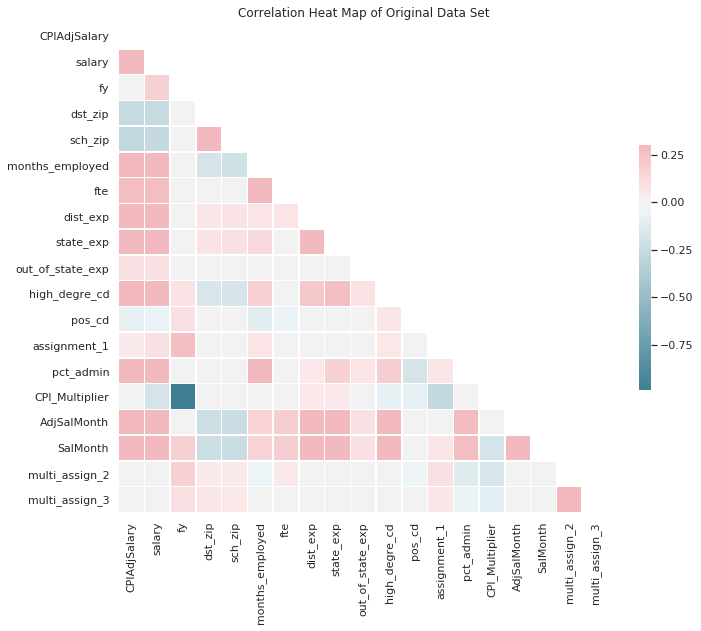

In [0]:
#Generate Correlation Heat Map for Original Data
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Correlation Heat Map of Original Data Set')

In [0]:
corr

,CPIAdjSalary,salary,fy,dst_zip,sch_zip,months_employed,fte,dist_exp,state_exp,out_of_state_exp,high_degre_cd,pos_cd,assignment_1,pct_admin,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3
CPIAdjSalary,1.000000,0.981891,0.010020,-0.256581,-0.269910,0.450579,0.278496,0.497798,0.556617,0.098400,0.438942,-0.078844,0.039593,0.431342,-0.008184,0.919720,0.905289,-0.024363,-0.026065
salary,0.981891,1.000000,0.185133,-0.254376,-0.267397,0.448064,0.275654,0.476870,0.534108,0.092857,0.441851,-0.062915,0.084764,0.422260,-0.184125,0.901236,0.924985,0.004895,-0.007961
fy,0.010020,0.185133,1.000000,-0.010016,-0.013936,0.031776,0.013284,-0.039825,-0.041827,-0.020873,0.074245,0.088145,0.270901,0.002661,-0.988601,-0.000419,0.188141,0.171352,0.102557
dst_zip,-0.256581,-0.254376,-0.010016,1.000000,0.996162,-0.178532,0.005133,0.067672,0.079948,0.005421,-0.167269,-0.028194,-0.008926,0.008919,0.009956,-0.231392,-0.230105,0.040612,0.058453
sch_zip,-0.269910,-0.267397,-0.013936,0.996162,1.000000,-0.195873,0.012369,0.079740,0.086500,0.005991,-0.169086,-0.028164,-0.011100,0.002911,0.013954,-0.235273,-0.234262,0.041384,0.057231
months_employed,0.450579,0.448064,0.031776,-0.178532,-0.195873,1.000000,0.297197,0.070481,0.124014,0.027486,0.180525,-0.108219,0.072136,0.506329,-0.034314,0.162168,0.167876,-0.049196,-0.014975
fte,0.278496,0.275654,0.013284,0.005133,0.012369,0.297197,1.000000,0.073477,0.032647,-0.002243,0.025817,-0.058624,0.024041,0.019258,-0.014957,0.191758,0.192715,0.044766,0.032453
dist_exp,0.497798,0.476870,-0.039825,0.067672,0.079740,0.070481,0.073477,1.000000,0.889938,-0.027300,0.216763,-0.031485,0.024305,0.044990,0.044396,0.511535,0.490820,-0.021272,-0.007930
state_exp,0.556617,0.534108,-0.041827,0.079948,0.086500,0.124014,0.032647,0.889938,1.000000,-0.030252,0.272142,-0.036218,0.029651,0.171307,0.045985,0.554580,0.532951,-0.025222,-0.010360
out_of_state_exp,0.098400,0.092857,-0.020873,0.005421,0.005991,0.027486,-0.002243,-0.027300,-0.030252,1.000000,0.073848,-0.010837,-0.003756,0.072429,0.019985,0.092733,0.087482,-0.012465,-0.009269


In [0]:
#dropping row where gender is ' '
df = df.drop(df[df.gender==' '].index)
df.shape

(1497525, 44)

In [0]:
print(df['gender'].value_counts())

F    1144289
M     353236
Name: gender, dtype: int64


Text(0.5, 1.0, 'Distribution of Adjusted Monthly Salary by Gender')

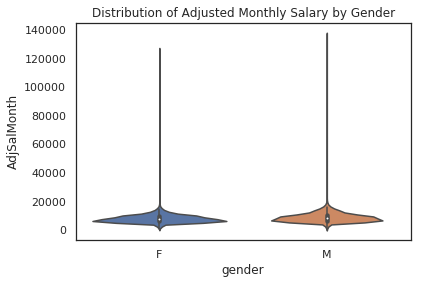

In [0]:
sns.violinplot(x='gender', y='AdjSalMonth', data=df).set_title('Distribution of Adjusted Monthly Salary by Gender')

In [0]:
#grouping ethnicities
def eth_assign(x):
    if x == 'White' or x == 'White, Non-Hispanic':
      return 'White'
    elif x == 'Black' or x == 'Black, Non-Hispanic' or x == 'Black or African American':
      return 'Black'
    elif x == 'Hispanic' or x == 'Hispanic or Latino':
      return 'Hispanic'
    elif x == 'Asian or Pacific Islander' or x == 'Native Hawaiian or Other Pacific Islander' or x == 'Asian':
      return 'Asian or Pacific Islander'
    elif x == 'American Indian or Alaska Native' or x == 'American Indian or Alaskan Native':
      return 'American Indian or Alaska Native'
    else:
      return 'Unknown'
       

df["eth_groups"] = df["race_ethnicity_desc"].apply(eth_assign)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

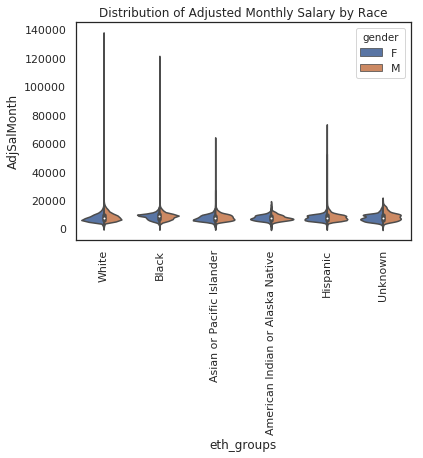

In [0]:
sns.violinplot(x='eth_groups', y='AdjSalMonth', data=df, hue='gender', split=True).set_title('Distribution of Adjusted Monthly Salary by Race')
plt.xticks(rotation=90)

In [0]:
#grouping education level
def edu_assign(x):
    if x == 'Masters':
      return 'Masters'
    elif x == 'Baccalaureate':
      return 'Bachelors'
    elif x == 'Doctorate':
      return 'Doctorate'
    elif x == 'None':
      return 'None'
    else:
      return 'Other'
       

df["edu_groups"] = df["high_degre_desc"].apply(edu_assign)

In [0]:
#checking counts for each
print(df['eth_groups'].value_counts())
print(df['edu_groups'].value_counts())

White                               1271918
Black                                130558
Hispanic                              67519
Asian or Pacific Islander             17339
Unknown                                7814
American Indian or Alaska Native       2377
Name: eth_groups, dtype: int64
Masters      857490
Bachelors    621121
Doctorate     12433
None           3468
Other          3013
Name: edu_groups, dtype: int64


In [0]:
#deleting original ethnicity, education, and location_cd columns - no longer needed for analysis
df = df.drop(['high_degre_cd', 'high_degre_desc', 'race_ethnicity_cd', 'race_ethnicity_desc', 'location_cd'],axis=1)

Text(0.5, 1.0, 'Distribution of Adjusted Monthly Salary by Education Level')

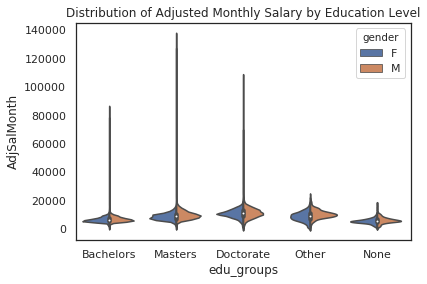

In [0]:
sns.violinplot(x='edu_groups', y='AdjSalMonth', data=df, hue='gender', split=True).set_title('Distribution of Adjusted Monthly Salary by Education Level')

In [0]:
print(df['pos_desc'].value_counts())

Elementary Teacher                     562826
High School Teacher                    339997
Junior High/Middle Teacher             204906
Special Education Teacher              185310
Guidance Counselor                      30456
Elementary Principal                    22950
Social Worker                           21911
Librarian/Media Specialist              20071
Speech/Language Pathologist             17778
Assistant Elementary Principal           9263
Psychologist                             9169
Reading Specialist                       8417
Assistant High School Principal          7991
High School Principal                    6866
Nurse                                    6459
Junior High/Middle Principal             5871
Kindergarten                             5629
Assistant Jr High/Middle Principal       5030
Director                                 3857
Student Dean                             3651
Coordinator                              3513
Program Supervisor                

In [0]:
#removing non-teacher cases by creating variable of those to drop
def pos_drop(x):
    if x == 18:
      return 1
    elif x == 19:
      return 1
    elif x == 20: 
      return 1
    elif x == 22: 
      return 1
    elif x == 63:
      return 1
    elif x == 64: 
      return 1
    else:
      return 0

df["pos_drop"] = df["pos_cd"].apply(pos_drop) 
print(df['pos_drop'].value_counts())

1    1301569
0     195956
Name: pos_drop, dtype: int64


In [0]:
# Delete these rows from dataFrame
df = df[df.pos_drop == 1]
df.shape

(1301569, 42)

In [0]:
#recoding high and low grades taught
print(df['high_grade'].value_counts())
print(df['high_grd_desc'].value_counts())

12    378676
08    258971
05    147043
03     84527
06     79973
04     72237
02     67211
01     66502
0K     50594
07     34717
0N     22493
09     19752
10     10541
11      7952
00       360
0k        20
Name: high_grade, dtype: int64
Twelfth         378676
Eighth          258971
Fifth           147043
Third            84527
Sixth            79973
Fourth           72237
Second           67211
First            66502
Kindergarten     50614
Seventh          34717
Preschool        22493
Ninth            19752
Tenth            10541
Eleventh          7952
NONE               360
Name: high_grd_desc, dtype: int64


In [0]:
#recoding highest grade taught
def high_grd(x):
    if x == '0N':
      return -2
    elif x == '0k':
      return -1
    elif x == '0K':
      return -1
    else:
      return x

df["grade_taught"] = df["high_grade"].apply(high_grd)
print(df['grade_taught'].value_counts())

12    378676
08    258971
05    147043
03     84527
06     79973
04     72237
02     67211
01     66502
-1     50614
07     34717
-2     22493
09     19752
10     10541
11      7952
00       360
Name: grade_taught, dtype: int64


In [0]:
#merging location variable
def loc_desc(x):
    if x == 'One School in this District':
      return 'OneSch_Taught'
    elif x == 'One School this District, plus other Districts':
      return 'OneSch_Taught'
    elif x == 'Multiple Schools in this District':
      return 'Multi_Taught'
    elif x == 'Multiple Schools this District, plus other Districts':
      return 'Multi_Taught'

df["loc_taught"] = df["location_desc"].apply(loc_desc)
print(df['loc_taught'].value_counts())

OneSch_Taught    1237100
Multi_Taught       64469
Name: loc_taught, dtype: int64


In [0]:
#print(df.groupby(['assignment_1', 'assign1_desc']).size().to_string())

In [0]:
# creating assignment 1 description groups 
def assign_group(x):
    if x in [1, 2, 3, 4, 6, 22, 23, 24, 25, 26, 59, 68, 69, 330, 331, 333, 334, 335, 336]:
      return 1
    elif x in [7, 8, 9, 10, 11, 12, 108, 115, 353, 354, 355, 356, 357, 358, 359, 360, 502]:
      return 2
    elif x in [13, 14, 15, 16, 17, 18, 19, 20, 21, 48, 49, 88, 94, 339, 346, 348, 350]: 
      return 3
    elif x in [5, 33, 34, 35, 36, 153, 351]: 
      return 4
    elif x in [50, 51, 73, 75, 76, 77, 78, 79, 81, 82, 83, 84, 89, 96, 98, 167, 361, 362, 363, 364, 365, 367, 601, 603, 604, 605, 606, 607]:
      return 5
    else:
      return 6

df["assign1_groups"] = df["assignment_1"].apply(assign_group) 
print(df['assign1_groups'].value_counts())

6    720311
3    159873
4    148555
1    120009
5     81724
2     71097
Name: assign1_groups, dtype: int64


In [0]:
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_addr,dst_city,dst_zip,sch_num,sch_name,sch_addr,sch_city,sch_zip,sch_zip_plus4,gender,location_desc,emply_desc,months_employed,fte,dist_exp,state_exp,out_of_state_exp,pos_cd,pos_desc,low_grade,low_grd_desc,high_grade,high_grd_desc,assignment_1,assign1_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3,z_score,eth_groups,edu_groups,pos_drop,grade_taught,loc_taught,assign1_groups
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,980 Park Ave,Genoa,60135.0,1003,Genoa-Kingston Middle School,941 W Main St,Genoa,60135.0,1037,F,One School in this District,Full-Time,9,100,1.0,1.0,0.0,20,Junior High/Middle Teacher,00,NONE,07,Seventh,21,Other Math,0.0,601,Suburb,1.39902,4029.489540,2880.222222,0,0,1.396285,White,Bachelors,1,07,OneSch_Taught,3
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,1235 Oak St,Winnetka,60093.0,1005,Carleton W Washburne School,515 Hibbard Rd,Winnetka,60093.0,1617,F,One School in this District,Full-Time,9,100,23.0,27.0,1.0,20,Junior High/Middle Teacher,07,Seventh,08,Eighth,47,Other Subject or Prog Areas Not Listed,0.0,600,Suburb,1.39902,12889.019160,9212.888889,0,0,1.772706,White,Masters,1,08,OneSch_Taught,6
3,78017.979429,55766.15,2003,31045046022,SD U-46,355 E Chicago St,Elgin,60120.0,1003,Abbott Middle School,949 Van St,Elgin,60123.0,6131,F,One School in this District,Full-Time,9,100,12.0,12.0,0.0,20,Junior High/Middle Teacher,07,Seventh,08,Eighth,140,Other Family & Consumer Sciences Occupations,0.0,601,Suburb,1.39902,8668.664381,6196.238889,0,0,0.263115,White,Masters,1,08,OneSch_Taught,6
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,5500 S Grant St,Hinsdale,60521.0,0002,Hinsdale South High School,7401 Clarendon Hills,Darien,60561.0,4288,F,One School in this District,Full-Time,10,100,5.0,5.0,8.0,22,High School Teacher,09,Ninth,12,Twelfth,1,English (Grades 9-12 Only),0.0,605,Suburb,1.39902,10681.660375,7635.100000,0,0,0.983149,White,Masters,1,12,OneSch_Taught,1
5,80121.896203,57270.00,2003,05016028002,Northbrook SD 28,1475 Maple Ave,Northbrook,60062.0,2002,Greenbriar Elem School,1225 Greenbriar Ln,Northbrook,60062.0,4522,F,One School in this District,Full-Time,10,100,1.0,2.0,9.0,19,Elementary Teacher,01,First,05,Fifth,34,Vocal Music,0.0,600,Suburb,1.39902,8012.189620,5727.000000,0,0,0.028299,White,Doctorate,1,05,OneSch_Taught,4


In [0]:
# create dataframe for CatBoost
df_cat = df
df_cat = df_cat.drop(['CPIAdjSalary', 'salary', 'fy', 'rcdt', 'dst_name','dst_addr','dst_city','dst_zip', 'sch_name','sch_addr',
                      'sch_city', 'sch_zip','sch_zip_plus4', 'location_desc', 'pos_desc', 'low_grd_desc', 'high_grd_desc', 
                      'assignment_1', 'assign1_desc', 'CPI_Multiplier', 'SalMonth', 'z_score', 'pos_drop'] ,axis=1)

#moving AdjSalMonth to first column
cols = df_cat.columns.tolist()
cols.insert(0, cols.pop(cols.index('AdjSalMonth')))
cols

df_cat = df_cat.reindex(columns= cols)
df_cat.head(10)

,AdjSalMonth,sch_num,gender,emply_desc,months_employed,fte,dist_exp,state_exp,out_of_state_exp,pos_cd,low_grade,high_grade,pct_admin,first_3,Zip_Type,multi_assign_2,multi_assign_3,eth_groups,edu_groups,grade_taught,loc_taught,assign1_groups
0,4029.489540,1003,F,Full-Time,9,100,1.0,1.0,0.0,20,00,07,0.0,601,Suburb,0,0,White,Bachelors,07,OneSch_Taught,3
1,12889.019160,1005,F,Full-Time,9,100,23.0,27.0,1.0,20,07,08,0.0,600,Suburb,0,0,White,Masters,08,OneSch_Taught,6
3,8668.664381,1003,F,Full-Time,9,100,12.0,12.0,0.0,20,07,08,0.0,601,Suburb,0,0,White,Masters,08,OneSch_Taught,6
4,10681.660375,0002,F,Full-Time,10,100,5.0,5.0,8.0,22,09,12,0.0,605,Suburb,0,0,White,Masters,12,OneSch_Taught,1
5,8012.189620,2002,F,Full-Time,10,100,1.0,2.0,9.0,19,01,05,0.0,600,Suburb,0,0,White,Doctorate,05,OneSch_Taught,4
6,7298.253984,2002,F,Full-Time,9,100,9.0,9.0,0.0,20,00,06,0.0,600,Suburb,0,0,White,Masters,06,OneSch_Taught,6
7,8576.624386,0030,F,Full-Time,9,100,8.0,8.0,0.0,22,09,12,0.0,606,Chicago,0,0,White,Bachelors,12,OneSch_Taught,4
8,7031.448365,1017,M,Full-Time,10,100,3.0,3.0,0.0,20,00,06,0.0,601,Suburb,1,1,White,Masters,06,OneSch_Taught,1
9,7751.625187,0013,M,Full-Time,9,100,2.0,2.0,0.0,22,09,12,0.0,605,Suburb,0,0,White,Masters,12,OneSch_Taught,3
10,6745.656485,0001,F,Full-Time,10,100,3.0,3.0,0.0,22,09,12,0.0,602,Other,0,0,White,Masters,12,OneSch_Taught,2


In [0]:
# Command to download the CSV file to your Google Drive. File is df_cat.csv
df_cat.to_csv('df_cat.csv')
!cp df_cat.csv drive/My\ Drive/

In [0]:
primary_cat = df_cat[df_cat["grade_taught"].isin([-1, -2, '00', '01', '02', '03', '04', '05', '06', '07', '08'])]
primary_cat.head(10)

,AdjSalMonth,sch_num,gender,emply_desc,months_employed,fte,dist_exp,state_exp,out_of_state_exp,pos_cd,low_grade,high_grade,pct_admin,first_3,Zip_Type,multi_assign_2,multi_assign_3,eth_groups,edu_groups,grade_taught,loc_taught,assign1_groups
0,4029.489540,1003,F,Full-Time,9,100,1.0,1.0,0.0,20,00,07,0.0,601,Suburb,0,0,White,Bachelors,07,OneSch_Taught,3
1,12889.019160,1005,F,Full-Time,9,100,23.0,27.0,1.0,20,07,08,0.0,600,Suburb,0,0,White,Masters,08,OneSch_Taught,6
3,8668.664381,1003,F,Full-Time,9,100,12.0,12.0,0.0,20,07,08,0.0,601,Suburb,0,0,White,Masters,08,OneSch_Taught,6
5,8012.189620,2002,F,Full-Time,10,100,1.0,2.0,9.0,19,01,05,0.0,600,Suburb,0,0,White,Doctorate,05,OneSch_Taught,4
6,7298.253984,2002,F,Full-Time,9,100,9.0,9.0,0.0,20,00,06,0.0,600,Suburb,0,0,White,Masters,06,OneSch_Taught,6
8,7031.448365,1017,M,Full-Time,10,100,3.0,3.0,0.0,20,00,06,0.0,601,Suburb,1,1,White,Masters,06,OneSch_Taught,1
11,5442.400465,2288,F,Full-Time,10,100,1.0,1.0,0.0,19,00,06,0.0,606,Chicago,0,0,White,Masters,06,OneSch_Taught,6
12,4960.632414,2023,F,Full-Time,9,100,2.0,2.0,0.0,19,00,02,0.0,611,Other,0,0,White,Bachelors,02,OneSch_Taught,6
16,5100.983691,2007,F,Full-Time,9,100,1.0,6.0,0.0,19,00,01,0.0,604,Suburb,0,0,White,Masters,01,OneSch_Taught,6
18,7474.190743,2006,F,Full-Time,10,100,12.0,12.0,12.0,19,00,01,0.0,601,Suburb,0,0,White,Bachelors,01,OneSch_Taught,6


In [0]:
primary_cat.shape

(884648, 22)

In [0]:
secondary_cat = df_cat[df_cat["grade_taught"].isin(['09', '10', '11', '12'])]
secondary_cat.head(10)

,AdjSalMonth,sch_num,gender,emply_desc,months_employed,fte,dist_exp,state_exp,out_of_state_exp,pos_cd,low_grade,high_grade,pct_admin,first_3,Zip_Type,multi_assign_2,multi_assign_3,eth_groups,edu_groups,grade_taught,loc_taught,assign1_groups
4,10681.660375,0002,F,Full-Time,10,100,5.0,5.0,8.0,22,09,12,0.0,605,Suburb,0,0,White,Masters,12,OneSch_Taught,1
7,8576.624386,0030,F,Full-Time,9,100,8.0,8.0,0.0,22,09,12,0.0,606,Chicago,0,0,White,Bachelors,12,OneSch_Taught,4
9,7751.625187,0013,M,Full-Time,9,100,2.0,2.0,0.0,22,09,12,0.0,605,Suburb,0,0,White,Masters,12,OneSch_Taught,3
10,6745.656485,0001,F,Full-Time,10,100,3.0,3.0,0.0,22,09,12,0.0,602,Other,0,0,White,Masters,12,OneSch_Taught,2
13,10413.767562,0004,F,Full-Time,10,100,16.0,16.0,5.0,22,09,12,0.0,600,Suburb,0,0,White,Masters,12,OneSch_Taught,1
17,12778.092390,3743,F,Full-Time,9,100,35.0,35.0,0.0,18,09,12,0.0,606,Chicago,0,0,White,Bachelors,12,OneSch_Taught,5
22,8043.434408,0764,F,Full-Time,9,100,4.0,4.0,0.0,22,09,12,0.0,606,Chicago,0,0,White,Doctorate,12,OneSch_Taught,1
29,5304.463431,0001,M,Full-Time,9,100,4.0,4.0,0.0,22,0K,12,0.0,626,Other,0,0,White,Bachelors,12,Multi_Taught,4
30,7298.984584,0001,F,Full-Time,9,100,9.0,9.0,0.0,22,09,12,0.0,605,Suburb,0,0,White,Masters,12,OneSch_Taught,3
31,10963.003370,0001,M,Full-Time,10,100,10.0,10.0,0.0,22,09,12,0.0,600,Suburb,0,0,White,Masters,12,OneSch_Taught,2


In [0]:
secondary_cat.shape

(416921, 22)

In [0]:
# Command to download the CSV file to your Google Drive. File is primary_cat.csv
primary_cat.to_csv('primary_cat.csv')
!cp primary_cat.csv drive/My\ Drive/

In [0]:
# Command to download the CSV file to your Google Drive. File is secondary_cat.csv
secondary_cat.to_csv('secondary_cat.csv')
!cp secondary_cat.csv drive/My\ Drive/

In [0]:
#creating dummies for gender, ethnicity, education, pos_desc
gen_dummy = pd.get_dummies(df['gender'])
eth_dummy = pd.get_dummies(df['eth_groups'])
edu_dummy = pd.get_dummies(df['edu_groups'])
pos_dummy = pd.get_dummies(df['pos_desc'])
loc_dummy = pd.get_dummies(df['loc_taught'])
zip_dummy = pd.get_dummies(df['Zip_Type'])

In [0]:
#renaming gender dummies
gen_dummy.columns = ['Female', 'Male']
gen_dummy.head(5)

,Female,Male
0,1,0
1,1,0
3,1,0
4,1,0
5,1,0


In [0]:
#renaming ethnicity dummies
eth_dummy.columns = ['AmerIn_Alaska', 'Asian_Pacific', 'Black', 'Hispanic', 'Eth_unknown', 'White']
eth_dummy.head(5)

,AmerIn_Alaska,Asian_Pacific,Black,Hispanic,Eth_unknown,White
0,0,0,0,0,0,1
1,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1
5,0,0,0,0,0,1


In [0]:
#renaming education dummies
edu_dummy.columns = ['Bachelors', 'Doctorate', 'Masters', 'Edu_None', 'Edu_Other']
edu_dummy.head(5)

,Bachelors,Doctorate,Masters,Edu_None,Edu_Other
0,1,0,0,0,0
1,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
5,0,1,0,0,0


In [0]:
#renaming teacher position dummies
pos_dummy.columns = ['Elem_Teacher', 'HS_Teacher', 'JuniorHS_Teacher', 'Kinder_Teacher', 'PreK_Teacher','SpecEd_Teacher']
pos_dummy.head(5)

,Elem_Teacher,HS_Teacher,JuniorHS_Teacher,Kinder_Teacher,PreK_Teacher,SpecEd_Teacher
0,0,0,1,0,0,0
1,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,1,0,0,0,0
5,1,0,0,0,0,0


In [0]:
#renaming zip type dummies
zip_dummy.columns = ['Chicago', 'Other', 'Suburb']
zip_dummy.head(5)

,Chicago,Other,Suburb
0,0,0,1
1,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1


In [0]:
#creating dummies for the assignment1 groups
assign_dummy = pd.get_dummies(df['assign1_groups'])
assign_dummy.head(5)

,1,2,3,4,5,6
0,0,0,1,0,0,0
1,0,0,0,0,0,1
3,0,0,0,0,0,1
4,1,0,0,0,0,0
5,0,0,0,1,0,0


In [0]:
#renaming assignment1 group dummies
assign_dummy.columns = ['Lit/Language', 'Humanities/SS', 'Math/Science', 'Art/PE', 'SpecialEd','Misc.']
assign_dummy.head(10)

,Lit/Language,Humanities/SS,Math/Science,Art/PE,SpecialEd,Misc.
0,0,0,1,0,0,0
1,0,0,0,0,0,1
3,0,0,0,0,0,1
4,1,0,0,0,0,0
5,0,0,0,1,0,0
6,0,0,0,0,0,1
7,0,0,0,1,0,0
8,1,0,0,0,0,0
9,0,0,1,0,0,0
10,0,1,0,0,0,0


In [0]:
df.shape

(1301569, 45)

In [0]:
new_dummies = pd.concat([gen_dummy,edu_dummy,eth_dummy,pos_dummy, loc_dummy, zip_dummy, assign_dummy], axis=1)

In [0]:
new_dummies.head(20)

,Female,Male,Bachelors,Doctorate,Masters,Edu_None,Edu_Other,AmerIn_Alaska,Asian_Pacific,Black,Hispanic,Eth_unknown,White,Elem_Teacher,HS_Teacher,JuniorHS_Teacher,Kinder_Teacher,PreK_Teacher,SpecEd_Teacher,Multi_Taught,OneSch_Taught,Chicago,Other,Suburb,Lit/Language,Humanities/SS,Math/Science,Art/PE,SpecialEd,Misc.
0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
5,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
6,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
7,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
8,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0
9,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
10,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0


In [0]:
new_dummies.shape

(1301569, 30)

In [0]:
#merging dummy tables to main dataframe
df = pd.concat([df,new_dummies], axis = 1)
df.shape

(1301569, 75)

In [0]:
#removing extra columns to create numerical dataframe
df_num = df.drop(['dst_name','dst_addr','dst_city','dst_zip', 'sch_name','sch_addr','sch_city','sch_zip','sch_zip_plus4', 'gender',
                  'location_desc'] ,axis=1)
df_num.dtypes

CPIAdjSalary        float64
salary              float64
fy                    int64
rcdt                 object
sch_num              object
emply_desc           object
months_employed       int64
fte                   int64
dist_exp            float64
state_exp           float64
out_of_state_exp    float64
pos_cd                int64
pos_desc             object
low_grade            object
low_grd_desc         object
high_grade           object
high_grd_desc        object
assignment_1          int64
assign1_desc         object
pct_admin           float64
first_3              object
Zip_Type             object
CPI_Multiplier      float64
AdjSalMonth         float64
SalMonth            float64
multi_assign_2        int64
multi_assign_3        int64
z_score             float64
eth_groups           object
edu_groups           object
                     ...   
Female                uint8
Male                  uint8
Bachelors             uint8
Doctorate             uint8
Masters             

In [0]:
#removing more non-numerical columns
df_num = df_num.drop(['emply_desc','loc_taught','eth_groups','edu_groups','pos_cd','pos_desc','pos_drop','low_grade','high_grade',
                      'low_grd_desc','high_grd_desc', 'assignment_1', 'assign1_desc', 'assign1_groups'] ,axis=1)
df_num.dtypes

CPIAdjSalary        float64
salary              float64
fy                    int64
rcdt                 object
sch_num              object
months_employed       int64
fte                   int64
dist_exp            float64
state_exp           float64
out_of_state_exp    float64
pct_admin           float64
first_3              object
Zip_Type             object
CPI_Multiplier      float64
AdjSalMonth         float64
SalMonth            float64
multi_assign_2        int64
multi_assign_3        int64
z_score             float64
grade_taught         object
Female                uint8
Male                  uint8
Bachelors             uint8
Doctorate             uint8
Masters               uint8
Edu_None              uint8
Edu_Other             uint8
AmerIn_Alaska         uint8
Asian_Pacific         uint8
Black                 uint8
Hispanic              uint8
Eth_unknown           uint8
White                 uint8
Elem_Teacher          uint8
HS_Teacher            uint8
JuniorHS_Teacher    

In [0]:
#removing additional variables to get numerical dataframe
df_num = df_num.drop(['rcdt', 'sch_num', 'Zip_Type', 'CPI_Multiplier', 'z_score', 'fy'] ,axis=1)
df_num.dtypes

CPIAdjSalary        float64
salary              float64
months_employed       int64
fte                   int64
dist_exp            float64
state_exp           float64
out_of_state_exp    float64
pct_admin           float64
first_3              object
AdjSalMonth         float64
SalMonth            float64
multi_assign_2        int64
multi_assign_3        int64
grade_taught         object
Female                uint8
Male                  uint8
Bachelors             uint8
Doctorate             uint8
Masters               uint8
Edu_None              uint8
Edu_Other             uint8
AmerIn_Alaska         uint8
Asian_Pacific         uint8
Black                 uint8
Hispanic              uint8
Eth_unknown           uint8
White                 uint8
Elem_Teacher          uint8
HS_Teacher            uint8
JuniorHS_Teacher      uint8
Kinder_Teacher        uint8
PreK_Teacher          uint8
SpecEd_Teacher        uint8
Multi_Taught          uint8
OneSch_Taught         uint8
Chicago             

In [0]:
# remove extra salary variables and move AdjSalMonth to the front 
df_num = df_num.drop(['CPIAdjSalary', 'salary', 'SalMonth'] ,axis=1)

#moving AdjSalMonth to first column
cols = df_num.columns.tolist()
cols.insert(0, cols.pop(cols.index('AdjSalMonth')))
cols

df_num = df_num.reindex(columns= cols)
df_num.head(10)

,AdjSalMonth,months_employed,fte,dist_exp,state_exp,out_of_state_exp,pct_admin,first_3,multi_assign_2,multi_assign_3,grade_taught,Female,Male,Bachelors,Doctorate,Masters,Edu_None,Edu_Other,AmerIn_Alaska,Asian_Pacific,Black,Hispanic,Eth_unknown,White,Elem_Teacher,HS_Teacher,JuniorHS_Teacher,Kinder_Teacher,PreK_Teacher,SpecEd_Teacher,Multi_Taught,OneSch_Taught,Chicago,Other,Suburb,Lit/Language,Humanities/SS,Math/Science,Art/PE,SpecialEd,Misc.
0,4029.489540,9,100,1.0,1.0,0.0,0.0,601,0,0,07,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,12889.019160,9,100,23.0,27.0,1.0,0.0,600,0,0,08,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,8668.664381,9,100,12.0,12.0,0.0,0.0,601,0,0,08,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
4,10681.660375,10,100,5.0,5.0,8.0,0.0,605,0,0,12,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
5,8012.189620,10,100,1.0,2.0,9.0,0.0,600,0,0,05,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
6,7298.253984,9,100,9.0,9.0,0.0,0.0,600,0,0,06,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
7,8576.624386,9,100,8.0,8.0,0.0,0.0,606,0,0,12,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
8,7031.448365,10,100,3.0,3.0,0.0,0.0,601,1,1,06,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0
9,7751.625187,9,100,2.0,2.0,0.0,0.0,605,0,0,12,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
10,6745.656485,10,100,3.0,3.0,0.0,0.0,602,0,0,12,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0


In [0]:
df_num.shape

(1301569, 41)

In [0]:
# Command to download the CSV file to your Google Drive. File is df_num.csv
df_num.to_csv('df_num.csv')
!cp df_num.csv drive/My\ Drive/

In [0]:
primary_num = df_num[df_num["grade_taught"].isin([-1, -2, '00', '01', '02', '03', '04', '05', '06', '07', '08'])]
primary_num.head(10)

,AdjSalMonth,months_employed,fte,dist_exp,state_exp,out_of_state_exp,pct_admin,first_3,multi_assign_2,multi_assign_3,grade_taught,Female,Male,Bachelors,Doctorate,Masters,Edu_None,Edu_Other,AmerIn_Alaska,Asian_Pacific,Black,Hispanic,Eth_unknown,White,Elem_Teacher,HS_Teacher,JuniorHS_Teacher,Kinder_Teacher,PreK_Teacher,SpecEd_Teacher,Multi_Taught,OneSch_Taught,Chicago,Other,Suburb,Lit/Language,Humanities/SS,Math/Science,Art/PE,SpecialEd,Misc.
0,4029.489540,9,100,1.0,1.0,0.0,0.0,601,0,0,07,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,12889.019160,9,100,23.0,27.0,1.0,0.0,600,0,0,08,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,8668.664381,9,100,12.0,12.0,0.0,0.0,601,0,0,08,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
5,8012.189620,10,100,1.0,2.0,9.0,0.0,600,0,0,05,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
6,7298.253984,9,100,9.0,9.0,0.0,0.0,600,0,0,06,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
8,7031.448365,10,100,3.0,3.0,0.0,0.0,601,1,1,06,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0
11,5442.400465,10,100,1.0,1.0,0.0,0.0,606,0,0,06,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
12,4960.632414,9,100,2.0,2.0,0.0,0.0,611,0,0,02,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
16,5100.983691,9,100,1.0,6.0,0.0,0.0,604,0,0,01,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
18,7474.190743,10,100,12.0,12.0,12.0,0.0,601,0,0,01,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [0]:
primary_num.shape

(884648, 41)

In [0]:
secondary_num = df_num[df_num["grade_taught"].isin(['09', '10', '11', '12'])]
secondary_num.head(10)

,AdjSalMonth,months_employed,fte,dist_exp,state_exp,out_of_state_exp,pct_admin,first_3,multi_assign_2,multi_assign_3,grade_taught,Female,Male,Bachelors,Doctorate,Masters,Edu_None,Edu_Other,AmerIn_Alaska,Asian_Pacific,Black,Hispanic,Eth_unknown,White,Elem_Teacher,HS_Teacher,JuniorHS_Teacher,Kinder_Teacher,PreK_Teacher,SpecEd_Teacher,Multi_Taught,OneSch_Taught,Chicago,Other,Suburb,Lit/Language,Humanities/SS,Math/Science,Art/PE,SpecialEd,Misc.
4,10681.660375,10,100,5.0,5.0,8.0,0.0,605,0,0,12,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
7,8576.624386,9,100,8.0,8.0,0.0,0.0,606,0,0,12,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
9,7751.625187,9,100,2.0,2.0,0.0,0.0,605,0,0,12,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
10,6745.656485,10,100,3.0,3.0,0.0,0.0,602,0,0,12,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
13,10413.767562,10,100,16.0,16.0,5.0,0.0,600,0,0,12,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
17,12778.092390,9,100,35.0,35.0,0.0,0.0,606,0,0,12,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0
22,8043.434408,9,100,4.0,4.0,0.0,0.0,606,0,0,12,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
29,5304.463431,9,100,4.0,4.0,0.0,0.0,626,0,0,12,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
30,7298.984584,9,100,9.0,9.0,0.0,0.0,605,0,0,12,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
31,10963.003370,10,100,10.0,10.0,0.0,0.0,600,0,0,12,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0


In [0]:
secondary_num.shape

(416921, 41)

In [0]:
# Command to download the CSV file to your Google Drive. File is primary_num.csv
primary_num.to_csv('primary_num.csv')
!cp primary_num.csv drive/My\ Drive/

In [0]:
# Command to download the CSV file to your Google Drive. File is secondary_num.csv
secondary_num.to_csv('secondary_num.csv')
!cp secondary_num.csv drive/My\ Drive/

In [0]:
score06 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_06_dist.xls?raw=true'
score07 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_07_dist.xls?raw=true'
score08 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_08_dist.xls?raw=true'
score09 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_09_dist.xls?raw=true'
score10 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_10_dist.xls?raw=true'
score11 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_11_dist.xlsx?raw=true'
score12 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_12_dist.xlsx?raw=true'

In [0]:
# merge test score datasets 
scores = pd.concat(map(pd.read_excel, [score06, score07, score08, score09, score10, score11, score12]))

In [0]:
scores.head(5)

,RCDTS,rcdt,County,Dist #,District Name/ School Name,City,3rd Grade Reading,3rd Grade Math,4th Grade Reading,4th Grade Math,5th Grade Reading,5th Grade Math,6th Grade Reading,6th Grade Math,7th Grade Reading,7th Grade Math,8th Grade Reading,8th Grade Math,11th Grade Reading,11th Grade Math,ISAT,PSAE,ACT Score,Enrollment,Year
0,010010010260000,01001001026,ADAMS,0010,PAYSON CUSD 1,PAYSON,70.6,91.2,85.1,97.9,82.5,90.0,78.8,88.5,71.4,69.0,78.7,82.0,65.9,46.3,82.2,54.5,18.3,599,2006
1,010010020260000,01001002026,ADAMS,0020,LIBERTY CUSD 2,LIBERTY,86.0,100.0,66.0,83.0,68.1,80.9,73.2,90.2,79.2,83.3,78.0,92.7,84.2,71.1,80.8,73.7,19.5,626,2006
2,010010030260000,01001003026,ADAMS,0030,CENTRAL CUSD 3,CAMP POINT,69.2,84.6,68.3,81.3,75.0,85.9,68.4,88.3,75.0,86.8,84.3,85.3,52.8,46.1,81.0,48.3,19.8,1053,2006
3,010010040260000,01001004026,ADAMS,0040,CUSD 4,MENDON,63.0,87.0,83.0,88.7,83.3,94.4,72.9,93.8,65.3,73.5,62.3,75.4,66.0,64.0,78.7,62.0,21.4,786,2006
4,010011720220000,01001172022,ADAMS,1720,QUINCY SD 172,QUINCY,75.9,88.1,76.1,87.7,76.5,81.8,76.0,85.4,73.2,81.9,78.0,76.5,50.3,52.7,80.4,49.2,19.7,6484,2006


In [0]:
# drop RCDTS, ISAT, PSAE, and ACT columns
scores = scores.drop(['RCDTS', 'ISAT', 'PSAE', 'ACT Score'],axis=1)

In [0]:
scores.shape

(6082, 21)

In [0]:
scores.count()

rcdt                          6082
County                        6082
Dist #                        6082
District Name/ School Name    6082
City                          6082
3rd Grade Reading             5192
3rd Grade Math                5193
4th Grade Reading             5204
4th Grade Math                5204
5th Grade Reading             5213
5th Grade Math                5214
6th Grade Reading             5213
6th Grade Math                5209
7th Grade Reading             5205
7th Grade Math                5203
8th Grade Reading             5208
8th Grade Math                5208
11th Grade Reading            3363
11th Grade Math               3363
Enrollment                    6082
Year                          6082
dtype: int64

In [0]:
# add columns with average reading and math score 
scores['Reading AVG'] = scores[['3rd Grade Reading', '4th Grade Reading', '5th Grade Reading', '6th Grade Reading', '7th Grade Reading', 
                                '8th Grade Reading', '11th Grade Reading']].mean(axis=1)
scores['Math AVG'] = scores[['3rd Grade Math', '4th Grade Math', '5th Grade Math', '6th Grade Math', '7th Grade Math', 
                                '8th Grade Math', '11th Grade Math']].mean(axis=1)
pd.set_option("display.max_columns", 35)

In [0]:
# drop grade level reading and math columns 
scores = scores.drop(['3rd Grade Reading', '4th Grade Reading', '5th Grade Reading', '6th Grade Reading', '7th Grade Reading', 
                      '8th Grade Reading', '11th Grade Reading', '3rd Grade Math', '4th Grade Math', '5th Grade Math', '6th Grade Math',
                      '7th Grade Math', '8th Grade Math', '11th Grade Math'],axis=1)
scores = scores.rename({'District Name/ School Name':'District Name'}, axis=1)
scores = scores.rename({'County ':'County'}, axis=1)

In [0]:
# capitalize County, District Name, and City values 
scores['County'] = scores['County'].str.upper()
scores['District Name'] = scores['District Name'].str.upper()
scores['City'] = scores['City'].str.upper()

In [0]:
# rename some counties so that they match
scores['County'].replace({'JO DAVIESS':'JODAVIESS', 'LA SALLE':'LASALLE', 'SAINT CLAIR':'ST. CLAIR'},inplace=True, regex=True)

In [0]:
scores.count()

rcdt             6082
County           6082
Dist #           6082
District Name    6082
City             6082
Enrollment       6082
Year             6082
Reading AVG      6029
Math AVG         6029
dtype: int64

In [0]:
# drop rows with no scores 
scores = scores.dropna()
scores.count()

rcdt             6029
County           6029
Dist #           6029
District Name    6029
City             6029
Enrollment       6029
Year             6029
Reading AVG      6029
Math AVG         6029
dtype: int64

In [0]:
# dataframe of AdjSalMonth, year, and rcdt codes
sal_df = df[['rcdt', 'fy', 'AdjSalMonth']].copy()


In [0]:
# district salary statistics dataframe
dist_sal = pd.DataFrame(sal_df.groupby(['rcdt', 'fy']).describe())
dist_sal.reset_index(inplace=True)
dist_sal.columns = ['rcdt', 'Year', 'AdjSalMonth count', 'AdjSalMonth mean', 'AdjSalMonth std', 'AdjSalMonth min', 'AdjSalMonth 25%', 
                   'AdjSalMonth median', 'AdjSalMonth 75%', 'AdjSalMonth max']

In [0]:
dist_sal.shape

(9849, 10)

In [0]:
# join dist_sal dataframe with scores dataframe
scores_df = pd.merge(dist_sal, scores, how='inner', on=['rcdt','Year'])

In [0]:
scores_df.shape

(5312, 17)

In [0]:
# add column for student to teacher ratio
scores_df['Students/Teacher'] = scores_df['Enrollment']/scores_df['AdjSalMonth count']

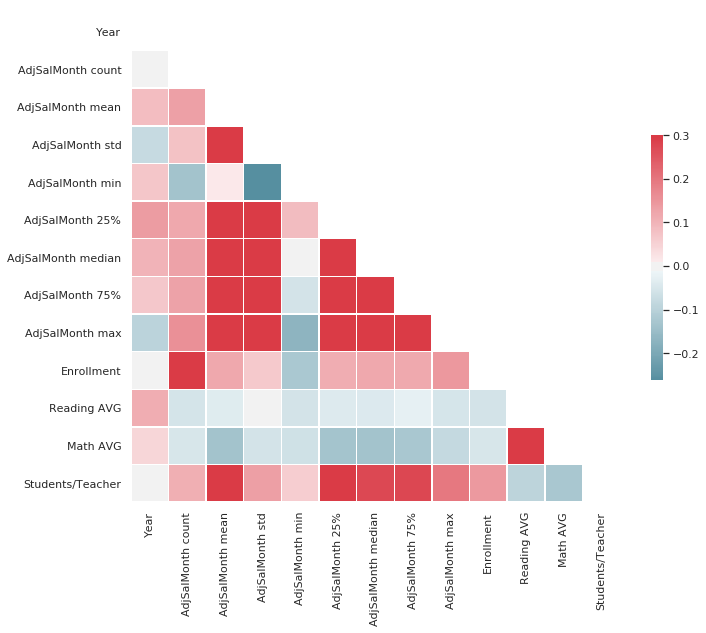

In [0]:
#heatmap
# Compute the correlation matrix
corr_mat = scores_df.corr()

# Generate a mask for the upper triangle
mask2 = np.zeros_like(corr_mat, dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_mat, mask=mask2, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Text(0.5, 1.0, 'Distribution of Average Math Scores')

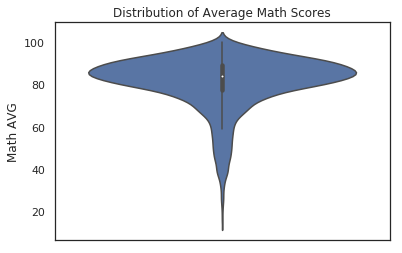

In [0]:
sns.violinplot(y='Math AVG', data=scores_df).set_title('Distribution of Average Math Scores')


Text(0.5, 1.0, 'Distribution of Average Reading Scores')

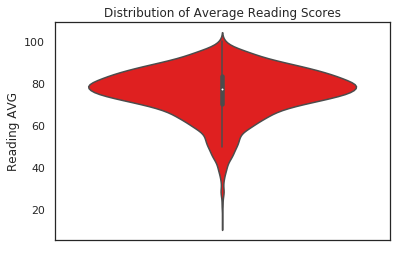

In [0]:
sns.violinplot(y='Reading AVG', data=scores_df, color='red').set_title('Distribution of Average Reading Scores')

Text(0.5, 1.0, 'Enrollment Distribution')

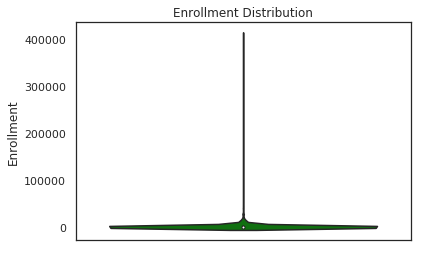

In [0]:
sns.violinplot(y='Enrollment', data=scores_df, color='green').set_title('Enrollment Distribution')

Text(0.5, 1.0, 'Student:Teacher Ratio Distribution')

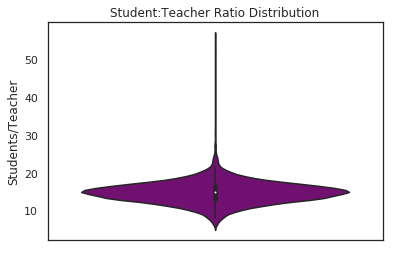

In [0]:
sns.violinplot(y='Students/Teacher', data=scores_df, color='purple').set_title('Student:Teacher Ratio Distribution')

In [0]:
# creating region groups by county
def region(x):
    if x in ['COOK']:
      return 1
    elif x in ['JODAVIESS', 'STEPHENSON', 'WINNEBAGO', 'BOONE', 'MCHENRY', 'LAKE', 'CARROLL', 'OGLE', 'DEKALB', 'KANE', 'DUPAGE', 
               'WHITESIDE', 'LEE', 'KENDALL', 'GRUNDY', 'WILL', 'KANKAKEE']:
      return 2
    elif x in ['ROCK ISLAND', 'MERCER', 'HENRY', 'BUREAU', 'LASALLE', 'HENDERSON', 'WARREN', 'KNOX', 'STARK', 'PUTNAM', 'MARSHALL', 
               'LIVINGSTON', 'FORD', 'IROQUOIS', 'VERMILION', 'CHAMPAIGN', 'MCLEAN', 'WOODFORD', 'TAZEWELL', 'MASON', 'PEORIA', 
               'FULTON', 'MCDONOUGH']: 
      return 3
    elif x in ['HANCOCK', 'ADAMS', 'SCHUYLER', 'BROWN', 'CASS', 'MENARD', 'LOGAN', 'DEWITT', 'PIATT', 'DOUGLAS', 'EDGAR', 'CLARK', 
               'COLES', 'CUMBERLAND', 'EFFINGHAM', 'SHELBY', 'MOULTRIE', 'MACON', 'CHRISTIAN', 'MONTGOMERY', 'SANGAMON', 'MORGAN', 
               'MACOUPIN', 'GREENE', 'JERSEY', 'CALHOUN', 'SCOTT', 'PIKE']: 
      return 4
    elif x in ['MADISON', 'BOND', 'FAYETTE', 'CLAY', 'JASPER', 'CRAWFORD', 'LAWRENCE', 'RICHLAND', 'EDWARDS', 'WABASH', 'WAYNE', 
               'MARION', 'CLINTON', 'ST. CLAIR', 'MONROE', 'RANDOLPH', 'WASHINGTON', 'JEFFERSON', 'PERRY', 'JACKSON', 'FRANKLIN', 
               'HAMILTON', 'WHITE', 'WILLIAMSON', 'SALINE', 'UNION', 'JOHNSON', 'POPE', 'HARDIN', 'ALEXANDER', 'PULASKI', 'MASSAC', 
               'GALLATIN']:
      return 5
    else:
      return 6

scores_df["Region"] = scores_df["County"].apply(region) 
print(scores_df['Region'].value_counts())


2    1634
3    1293
5    1273
4     819
1     293
Name: Region, dtype: int64


In [0]:
scores_df.head(10)

,rcdt,Year,AdjSalMonth count,AdjSalMonth mean,AdjSalMonth std,AdjSalMonth min,AdjSalMonth 25%,AdjSalMonth median,AdjSalMonth 75%,AdjSalMonth max,County,Dist #,District Name,City,Enrollment,Reading AVG,Math AVG,Students/Teacher,Region
0,01001001026,2006,41.0,5823.808369,1443.272985,2728.194087,4621.578094,5668.282853,6824.523933,8396.215003,ADAMS,0010,PAYSON CUSD 1,PAYSON,599,76.142857,80.700000,14.609756,4
1,01001001026,2007,41.0,5866.577022,1409.736353,3891.773646,4609.218263,5660.371240,7039.725301,8552.166251,ADAMS,0010,PAYSON CUSD 1,PAYSON,583,72.228571,78.514286,14.219512,4
2,01001001026,2008,42.0,5787.501672,1438.593892,3862.171813,4588.207807,5494.726392,7150.581684,8693.190019,ADAMS,0010,PAYSON CUSD 1,PAYSON,546,72.814286,77.414286,13.000000,4
3,01001001026,2009,42.0,5787.182596,1357.160452,4156.342831,4665.611790,5429.742638,6565.077581,9212.054290,ADAMS,0010,PAYSON CUSD 1,PAYSON,540,79.242857,83.071429,12.857143,4
4,01001001026,2010,43.0,5800.379166,1364.600901,4251.409746,4673.971790,5512.889369,6377.708352,9514.906034,ADAMS,0010,PAYSON CUSD 1,PAYSON,541,80.228571,84.671429,12.581395,4
5,01001001026,2011,43.0,5840.362705,1338.032064,3797.660581,4868.321764,5393.799818,6274.971523,8910.469425,ADAMS,0010,PAYSON CUSD 1,PAYSON,522,77.785714,83.485714,12.139535,4
6,01001001026,2012,42.0,5907.992745,1445.165296,4425.808987,4743.060089,5439.232587,6542.093269,9176.642543,ADAMS,0010,PAYSON CUSD 1,PAYSON,535,80.542857,86.642857,12.738095,4
7,01001002026,2006,45.0,5321.368388,918.197660,4019.388412,4496.263217,5327.901290,5861.789585,7800.688385,ADAMS,0020,LIBERTY CUSD 2,LIBERTY,626,76.385714,85.885714,13.911111,4
8,01001002026,2007,47.0,5354.516421,963.781148,3507.150764,4564.740267,5309.672490,5905.849291,8045.370842,ADAMS,0020,LIBERTY CUSD 2,LIBERTY,635,74.157143,83.614286,13.510638,4
9,01001002026,2008,49.0,5102.559690,913.525348,3965.611147,4242.493984,5099.485717,5695.786991,7926.631264,ADAMS,0020,LIBERTY CUSD 2,LIBERTY,636,75.314286,83.871429,12.979592,4


In [0]:
# create categorical dataframe
scores_cat = scores_df
scores_cat = scores_cat.drop(['rcdt', 'AdjSalMonth mean', 'AdjSalMonth std', 'AdjSalMonth min', 'AdjSalMonth 25%', 'AdjSalMonth 75%',
                           'AdjSalMonth max', 'District Name', 'City', 'Year'] ,axis=1)

# rename AdjSalMonth count to Teachers
scores_cat.rename(columns={'AdjSalMonth count': 'Teachers'}, inplace=True)

#moving AdjSalMonth median to first column
cols = scores_cat.columns.tolist()
cols.insert(0, cols.pop(cols.index('AdjSalMonth median')))
cols

scores_cat = scores_cat.reindex(columns= cols)
scores_cat.head(10)

,AdjSalMonth median,Teachers,County,Dist #,Enrollment,Reading AVG,Math AVG,Students/Teacher,Region
0,5668.282853,41.0,ADAMS,0010,599,76.142857,80.700000,14.609756,4
1,5660.371240,41.0,ADAMS,0010,583,72.228571,78.514286,14.219512,4
2,5494.726392,42.0,ADAMS,0010,546,72.814286,77.414286,13.000000,4
3,5429.742638,42.0,ADAMS,0010,540,79.242857,83.071429,12.857143,4
4,5512.889369,43.0,ADAMS,0010,541,80.228571,84.671429,12.581395,4
5,5393.799818,43.0,ADAMS,0010,522,77.785714,83.485714,12.139535,4
6,5439.232587,42.0,ADAMS,0010,535,80.542857,86.642857,12.738095,4
7,5327.901290,45.0,ADAMS,0020,626,76.385714,85.885714,13.911111,4
8,5309.672490,47.0,ADAMS,0020,635,74.157143,83.614286,13.510638,4
9,5099.485717,49.0,ADAMS,0020,636,75.314286,83.871429,12.979592,4


In [0]:
# Command to download the CSV file to your Google Drive. File is scores_cat.csv
scores_cat.to_csv('scores_cat.csv')
!cp scores_cat.csv drive/My\ Drive/

In [0]:
#creating dummies for the region groups
region_dummy = pd.get_dummies(scores_df['Region'])
region_dummy.head(5)

,1,2,3,4,5
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [0]:
#renaming region group dummies
region_dummy.columns = ['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5']
region_dummy.head(5)

,Region 1,Region 2,Region 3,Region 4,Region 5
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [0]:
#merging region dummy table to main dataframe
scores_df = pd.concat([scores_df,region_dummy], axis = 1)
scores_df.shape

(5312, 24)

In [0]:
scores_df.head(5)

,rcdt,Year,AdjSalMonth count,AdjSalMonth mean,AdjSalMonth std,AdjSalMonth min,AdjSalMonth 25%,AdjSalMonth median,AdjSalMonth 75%,AdjSalMonth max,County,Dist #,District Name,City,Enrollment,Reading AVG,Math AVG,Students/Teacher,Region,Region 1,Region 2,Region 3,Region 4,Region 5
0,01001001026,2006,41.0,5823.808369,1443.272985,2728.194087,4621.578094,5668.282853,6824.523933,8396.215003,ADAMS,0010,PAYSON CUSD 1,PAYSON,599,76.142857,80.700000,14.609756,4,0,0,0,1,0
1,01001001026,2007,41.0,5866.577022,1409.736353,3891.773646,4609.218263,5660.371240,7039.725301,8552.166251,ADAMS,0010,PAYSON CUSD 1,PAYSON,583,72.228571,78.514286,14.219512,4,0,0,0,1,0
2,01001001026,2008,42.0,5787.501672,1438.593892,3862.171813,4588.207807,5494.726392,7150.581684,8693.190019,ADAMS,0010,PAYSON CUSD 1,PAYSON,546,72.814286,77.414286,13.000000,4,0,0,0,1,0
3,01001001026,2009,42.0,5787.182596,1357.160452,4156.342831,4665.611790,5429.742638,6565.077581,9212.054290,ADAMS,0010,PAYSON CUSD 1,PAYSON,540,79.242857,83.071429,12.857143,4,0,0,0,1,0
4,01001001026,2010,43.0,5800.379166,1364.600901,4251.409746,4673.971790,5512.889369,6377.708352,9514.906034,ADAMS,0010,PAYSON CUSD 1,PAYSON,541,80.228571,84.671429,12.581395,4,0,0,0,1,0


In [0]:
# drop variables to get numerical dataframe
# AdjSalMonth median is the target variable 
scores_df = scores_df.drop(['rcdt', 'AdjSalMonth mean', 'AdjSalMonth std', 'AdjSalMonth min', 'AdjSalMonth 25%', 'AdjSalMonth 75%',
                           'AdjSalMonth max', 'County', 'Dist # ', 'District Name', 'City', 'Region', 'Year'] ,axis=1)
scores_df.head(5)

,AdjSalMonth count,AdjSalMonth median,Enrollment,Reading AVG,Math AVG,Students/Teacher,Region 1,Region 2,Region 3,Region 4,Region 5
0,41.0,5668.282853,599,76.142857,80.700000,14.609756,0,0,0,1,0
1,41.0,5660.371240,583,72.228571,78.514286,14.219512,0,0,0,1,0
2,42.0,5494.726392,546,72.814286,77.414286,13.000000,0,0,0,1,0
3,42.0,5429.742638,540,79.242857,83.071429,12.857143,0,0,0,1,0
4,43.0,5512.889369,541,80.228571,84.671429,12.581395,0,0,0,1,0


In [0]:
# rename AdjSalMonth count to Teachers
scores_df.rename(columns={'AdjSalMonth count': 'Teachers'}, inplace=True)

#moving AdjSalMonth median to first column
cols = scores_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('AdjSalMonth median')))
cols

scores_df = scores_df.reindex(columns= cols)
scores_df.head(5)

,AdjSalMonth median,Teachers,Enrollment,Reading AVG,Math AVG,Students/Teacher,Region 1,Region 2,Region 3,Region 4,Region 5
0,5668.282853,41.0,599,76.142857,80.700000,14.609756,0,0,0,1,0
1,5660.371240,41.0,583,72.228571,78.514286,14.219512,0,0,0,1,0
2,5494.726392,42.0,546,72.814286,77.414286,13.000000,0,0,0,1,0
3,5429.742638,42.0,540,79.242857,83.071429,12.857143,0,0,0,1,0
4,5512.889369,43.0,541,80.228571,84.671429,12.581395,0,0,0,1,0


In [0]:
scores_df.dtypes

AdjSalMonth median    float64
Teachers              float64
Enrollment              int64
Reading AVG           float64
Math AVG              float64
Students/Teacher      float64
Region 1                uint8
Region 2                uint8
Region 3                uint8
Region 4                uint8
Region 5                uint8
dtype: object

In [0]:
# Command to download the CSV file to your Google Drive. File is scores_df.csv
scores_df.to_csv('scores_df.csv')
!cp scores_df.csv drive/My\ Drive/

**MODEL CREATION**

---



In [0]:
### TEST TRAIN VALIDATION SPLIT ###

num_instances = df_num.shape[0]

Y = df_num['AdjSalMonth']
X = df_num.drop(['AdjSalMonth'], axis=1)

# Creating the train/test split
Y_train, Y_test, X_train, X_test = train_test_split(Y, X, test_size=0.3, random_state=33)  

# Splitting df_train into the train and then holding some out for validation
Y_train, Y_val, X_train, X_val = train_test_split(Y_train, X_train, test_size=0.143, random_state=33)

print("Confirming Splits...")
print("Y_TRAIN: " + str(Y_train.shape[0]) + " = " + str(round((Y_train.shape[0]/num_instances)*100, 2)) + "%")
print("Y_TEST: " + str(Y_test.shape[0]) + " = " + str(round((Y_test.shape[0]/num_instances)*100, 2)) + "%")
print("Y_VALIDATION: " + str(Y_val.shape[0]) + " = " + str(round((Y_val.shape[0]/num_instances)*100, 2)) + "%")

print()
print("X_TRAIN: " + str(X_train.shape[0]) +  ", " + str(X_train.shape[1]) + " = " + str(round((X_train.shape[0]/num_instances)*100, 2)) + "%")
print("X_TEST: " + str(X_test.shape[0]) +  ", " + str(X_test.shape[1]) + " = " + str(round((X_test.shape[0]/num_instances)*100, 2)) + "%")
print("X_VALIDATION: " + str(X_val.shape[0]) +  ", " + str(X_val.shape[1]) + " = " + str(round((X_val.shape[0]/num_instances)*100, 2)) + "%")

# This is a *close* Train/Test/Validation split of 60/30/10

# X_train, Y_train is the data set we should train all the models with
# X_test, Y_test is the data we will be testing our models on to assess accuracy
# X_val, Y_val is the validation data set 

Confirming Splits...
Y_TRAIN: 780810 = 59.99%
Y_TEST: 390471 = 30.0%
Y_VALIDATION: 130288 = 10.01%

X_TRAIN: 780810, 40 = 59.99%
X_TEST: 390471, 40 = 30.0%
X_VALIDATION: 130288, 40 = 10.01%


In [0]:
### FEATURE SELECTION ###

# We will need to flesh this out more.

In [0]:
### LINEAR REGRESSION ###

linear_model = LinearRegression()
linear_model.fit(X_train,Y_train)
r_squared = linear_model.score(X_train, Y_train)

print("Linear Regression Results\n")
print("COEFFICIENT OF DETERMINATION: ", round(r_squared, 5))

train_r_squared = linear_model.score(X_train, Y_train)
test_r_squared = linear_model.score(X_test, Y_test)
print("COEFFICIENT OF DETERMINATION - Train: ", train_r_squared)
print("COEFFICIENT OF DETERMINATION - Test: ", test_r_squared)

RMSE = math.sqrt(metrics.mean_squared_error(Y_train, linear_model.predict(X_train)))
print("\nLinear Regression RMSE: ", RMSE)
EV = metrics.explained_variance_score(Y_train, linear_model.predict(X_train))
print("Linear Regression Explained Variance: ", EV) 

Linear Regression Results

COEFFICIENT OF DETERMINATION:  0.58683
COEFFICIENT OF DETERMINATION - Train:  0.5868277780093627
COEFFICIENT OF DETERMINATION - Test:  0.5941099707824977

Linear Regression RMSE:  1700.20480712542
Linear Regression Explained Variance:  0.5868277780093628


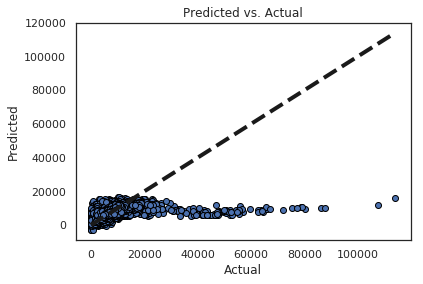

In [0]:
# Plot output
predicted = linear_model.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(Y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Predicted vs. Actual')
plt.show()

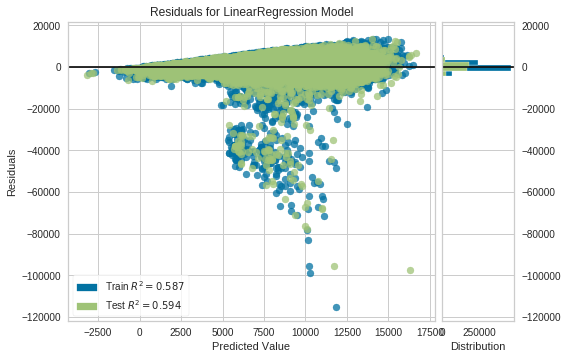

In [0]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
linear = LinearRegression()
visualizer = ResidualsPlot(linear)

visualizer.fit(X_train, Y_train)  # Fit the training data to the model
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.poof()     

In [0]:
### Decision Tree ###
from sklearn.tree import DecisionTreeRegressor
rgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=None)
rgr.fit(X_train,Y_train)
scores_ACC = rgr.score(X_train,Y_train)                                                                                                                          
print('Decision Tree Accuracy:', scores_ACC)

Decision Tree Accuracy: 0.4845166156615169


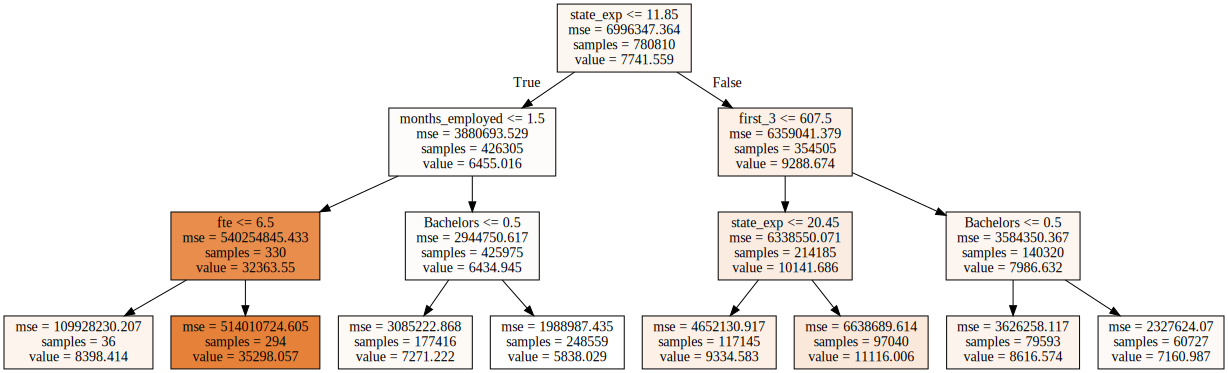

In [0]:
from graphviz import Source
from sklearn import tree
from IPython.display import SVG
import time

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

graph = Source(tree.export_graphviz(rgr, out_file=None,filled = True,feature_names=X_train.columns.values))
display(SVG(graph.pipe(format='svg')))

In [0]:
import math
scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
#SciKit Decision Tree Regressor - Cross Val
start_ts=time.time()
rgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=None) 
scores = cross_validate(rgr, X_train, y = Y_train, scoring = scorers, cv = 5)   

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Decision Tree RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Decision Tree Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

Decision Tree RMSE: 1904.89 (+/- 38.09)
Decision Tree Expl Var: 0.48 (+/- 0.01)
CV Runtime: 30.497270584106445


In [0]:
#Predict
rgr.fit(X_train,Y_train)
y_1 = rgr.predict(X_train)

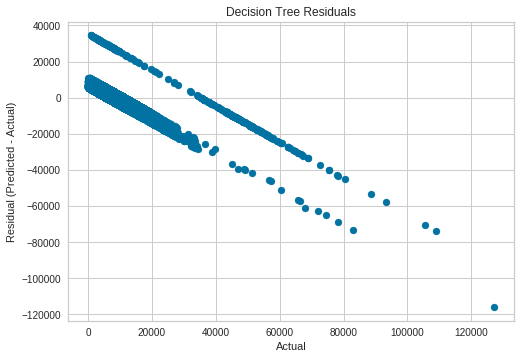

In [0]:
#Plot of Residuals
plt.scatter(x=Y_train, y=y_1-Y_train)
plt.title('Decision Tree Residuals')
plt.ylabel('Residual (Predicted - Actual)')
plt.xlabel('Actual')
plt.show()

In [0]:
Y_train

67859       6751.050486
311767      8616.756934
911141      6487.435167
1099205     6794.997173
382262     13702.297964
964582     10606.167096
885194      9406.485605
764742      5190.331740
1389866     6562.123218
251536      9115.305231
1049100     8021.544727
963416      9962.303792
934412      5844.068815
1363061     9144.544777
337491      6253.964604
1586129     8094.459289
1091802     6041.335190
230607      6034.171066
109932      7786.165445
942176      9818.218661
925049      5891.036211
959194      3900.568663
1500884    10135.332560
896574      8431.192234
657893      4937.820100
765326      5273.777807
1150213     7039.356878
130000      7133.449385
466729     10005.588003
253231      8810.587789
               ...     
1569875    10882.107516
130902      8447.844561
244642      6767.373330
204214      7494.139716
1209433     5214.054077
879404      7320.529862
429377      5557.652851
1344750    11334.999266
662148      5408.063325
622528     11940.699897
472137      8035

In [0]:
#normalizing data for KNN
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler().fit(X_train)
X_trainN = min_max_scaler.transform(X_train)
X_testN = min_max_scaler.transform(X_test)
X_valN = min_max_scaler.transform(X_val)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
#KNN cont'd
import time
print('KNN Results')
print()
start_ts=time.time()
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, metric='euclidean', metric_params=None).fit(X_trainN, Y_train)

train_r2_salKNN = knn.score(X_trainN, Y_train)
test_r2_salKNN = knn.score(X_testN, Y_test)
print("COEFFICIENT OF DETERMINATION - Train", train_r2_salKNN)
print("COEFFICIENT OF DETERMINATION - Test", test_r2_salKNN)
print()

RMSE = math.sqrt(metrics.mean_squared_error(Y_test, knn.predict(X_testN)))
print('KNN RMSE:', RMSE)
Expl_Var = metrics.explained_variance_score(Y_test, knn.predict(X_testN))
print('KNN Explained Variance:', Expl_Var) 

print("CV Runtime:", time.time()-start_ts)

KNN Results



In [0]:
#KNN visualizations - plot output

predicted = knn.predict(X_testN)

fig, ax = plt.subplots()
ax.scatter(Y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Predicted vs. Actual')
plt.show()

In [0]:
visualizer = ResidualsPlot(knn)

visualizer.fit(X_trainN, Y_train)  # Fit the training data to the model
visualizer.score(X_testN, Y_test)  # Evaluate the model on the test data
visualizer.poof()

In [0]:
### RANDOM FORESTS ###
print('Random Forest Results on teacher salary data')
print()
start_ts=time.time()
RF = RandomForestRegressor(n_estimators=100, criterion='mse', max_features=.33, max_depth=4, min_samples_split=2, random_state=12).fit(X_train, Y_train)

train_r2_salaryRF = RF.score(X_train, Y_train)
test_r2_salaryRF = RF.score(X_test, Y_test)
print("COEFFICIENT OF DETERMINATION - Train", train_r2_salaryRF)
print("COEFFICIENT OF DETERMINATION - Test", test_r2_salaryRF)
print()

RMSE_salRF = math.sqrt(metrics.mean_squared_error(Y_test, RF.predict(X_test)))
print('Random Forest RMSE on salary data:', RMSE_salRF)
ExplVar_salRF = metrics.explained_variance_score(Y_test, RF.predict(X_test))
print('Random Forest Explained Variance on salary data:', ExplVar_salRF) 

print("CV Runtime:", time.time()-start_ts)

In [0]:
#Random forest visualizations - printing results
important_features_dict = {}
features = X_train.columns.tolist()
for x,i in enumerate(RF.feature_importances_):
    important_features_dict[x]=i

# the index of the most important features in decreasing order
lst = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print('Most important features:')
for i in lst:
  print(features[i])

In [0]:
#Random forest plot outputs - salary data
predicted = RF.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(Y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Predicted vs. Actual')
plt.show()

In [0]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(RF)

visualizer.fit(X_train, Y_train)  # Fit the training data to the model
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.poof()

In [0]:
### GRADIENT BOOSTING ###
print("Gradient Boosting Results\n")

GB = GradientBoostingRegressor(n_estimators=100, loss='ls', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=88).fit(X_train, Y_train)

train_r_squared = GB.score(X_train, Y_train)
test_r_squared = GB.score(X_test, Y_test)
print("COEFFICIENT OF DETERMINATION - Train", train_r_squared)
print("COEFFICIENT OF DETERMINATION - Test", test_r_squared)
print()

RMSE = math.sqrt(metrics.mean_squared_error(Y_test, GB.predict(X_test)))
print('Gradient Boosting RMSE:', RMSE)
EV = metrics.explained_variance_score(Y_test, GB.predict(X_test))
print('Gradient Boosting Explained Variance:', EV) 

In [0]:
#Gradient boosting plot outputs - salary data
predicted = GB.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(Y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Predicted vs. Actual')
plt.show()

In [0]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(GB)

visualizer.fit(X_train, Y_train)  # Fit the training data to the model
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.poof()

In [0]:
### SVM - Either Linear, RBF, Sigmoid, Poly ###
print("SVM Results\n")
SVM = SVR(kernel='linear', gamma='auto', C=1.0).fit(X_train, Y_train)

train_r_squared = SVM.score(X_train, Y_train)
test_r_squared = SVM.score(X_train, Y_train)
print("COEFFICIENT OF DETERMINATION - Train", train_r_squared)
print("COEFFICIENT OF DETERMINATION - Test", test_r_squared)
print()

RMSE = math.sqrt(metrics.mean_squared_error(y_test_scores, SVM.predict(X_test)))
print('SVM RMSE:', RMSE)
Expl_Var = metrics.explained_variance_score(y_test_scores, SVM.predict(X_test))
print('SVM Explained Variance:', Expl_Var) 